# Анализ лояльности пользователей Яндекс Афиши

<div style="font-size: 24px; line-height: 1.5; color: blue;">
Цель проекта
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Определить признаки и причины по которым пользователи чаще используют сервис на основе доступных данных с целью:
    <ul>
<li>Определить перспективных клиентов и как можно быстрее поспособствовать их переходу на платформу засчет персонализированных условий</li>
<li>Оптимально проводить рекламные компании для уменьшения числа возвратов заказов</li>
<li>Оптимизировать маркетинговые издержки и повысить удержание клиентов</li>
</ul>
</div>

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
import os
from dotenv import load_dotenv

import numpy as np

import pandas as pd
from sqlalchemy import create_engine 

import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import requests
import io

In [2]:
load_dotenv('config.env')

True

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 

In [4]:
engine = create_engine(connection_string) 

In [5]:
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
        (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk::DATE
    )) AS days_since_prev,
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e USING (event_id)
JOIN afisha.city AS c USING (city_id)
JOIN afisha.regions AS r USING (region_id)
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [6]:
df = pd.read_sql_query(query, con=engine) 

In [7]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>В распоряжении 290611 строк и 14 столбцов</li>
<li>Пустые значения есть в столбце days_since_prev, т.к. это должно быть первый заказ пользователя и для него не получается посчитать значение ввиду отсутствия предыдущего</li>
<li>У столбца tickets_count можно уменьшить разрядность</li>
<li>Привести к нижнему регистру и проверить наличие дубликатов в столбцах currency_code, service_name, event_type_main, region_name, city_name </li>
<li>Проверить диапазоны значений в столбцах order_dt, order_ts, revenue, days_since_prev</li>
<li>Проверить валидность значений в столбцах tickets_count</li>
</ul>
</div>

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

In [10]:
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
response = requests.get(url, verify=False)
tenge_df = pd.read_csv(io.StringIO(response.text))

In [11]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [12]:
tenge_df['curs_per_unit'] = tenge_df['curs'] / tenge_df['nominal']
tenge_df.head()

,data,nominal,curs,cdx,curs_per_unit
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501


In [13]:
print(type(df['order_dt'].iloc[0]))
print(type(tenge_df['data'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'str'>


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Даты в разном формате, необходимо привести к одному виду
</div>

In [14]:
tenge_df['date_ts'] = pd.to_datetime(tenge_df['data'])
df['order_dt_ts'] = pd.to_datetime(df['order_dt'])

In [15]:
print(type(df['order_dt_ts'].iloc[0]))
print(type(tenge_df['date_ts'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [16]:
def get_exchange_rate(target_date):
    exact_match = tenge_df[tenge_df['date_ts'] == target_date]
    if not exact_match.empty:
        return exact_match['curs_per_unit'].iloc[0]
    
    # Ищем ближайшую предыдущую дату
    previous_rates = tenge_df[tenge_df['date_ts'] <= target_date]
    if not previous_rates.empty:
        return previous_rates.iloc[-1]['curs_per_unit']
    
    # Если нет предыдущих дат, берем самую раннюю доступную
    return tenge_df['curs_per_unit'].iloc[0]

In [17]:
get_exchange_rate(df['order_dt'].iloc[0])

np.float64(0.186972)

In [18]:
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub' 
    else row['revenue'] * get_exchange_rate(row['order_dt']),
    axis=1
)

In [19]:
print(df[df['currency_code'] == 'rub']['revenue'].mean())
df['revenue_rub'].mean()

548.0139292643464


np.float64(555.5719866752087)

In [20]:
df[df['currency_code'] == 'kzt'][['revenue', 'revenue_rub', 'currency_code']].head()

,revenue,revenue_rub,currency_code
70,518.10,98.503762,kzt
89,347.18,65.731589,kzt
96,328.77,61.148261,kzt
277,22021.55,4380.702898,kzt
460,7397.66,1478.296591,kzt


In [21]:
df[df['currency_code'] == 'rub'][['revenue', 'revenue_rub', 'currency_code']].head()

,revenue,revenue_rub,currency_code
0,1521.94,1521.94,rub
1,289.45,289.45,rub
2,1258.57,1258.57,rub
3,8.49,8.49,rub
4,1390.41,1390.41,rub


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Проверили среднее значение до и после конвертации а так же несколько значений после конвертации, чтобы убедиться в отсутствии очевидных ошибок. Учитывая что количество оплат в тенге меньше 2%, то среднее значение в рублях не должно сильно измениться - так и получилось - было 548, стало 556
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Теперь выручка скорректирована, и ее можно использовать для дальнейшего анализа
</div>

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [22]:
df['device_type_canonical'].value_counts()

device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

In [23]:
df['tickets_count'].value_counts()

tickets_count
3     92247
2     83807
4     54812
1     41798
5     13476
6      4283
7        62
9        38
8        21
10       19
11       13
13        7
17        6
19        5
12        4
14        4
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64

In [24]:
print(df['tickets_count'].min())
print(df['tickets_count'].max())
df['tickets_count'].dtype

1
57


dtype('int64')

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Разрядность для стобца количества билетов можно уменьшить до int16, т.к. наврят ли значение в этом столбце должно превышать 32к
</div>

In [25]:
df['tickets_count'] = df['tickets_count'].astype('int16')

In [26]:
df['tickets_count'].dtype

dtype('int16')

In [27]:
df['service_name'] = df['service_name'].str.lower()

In [28]:
df['service_name'].value_counts().head()

service_name
билеты без проблем    63519
лови билет!           41124
билеты в руки         40343
мой билет             34839
облачко               26642
Name: count, dtype: int64

In [29]:
df['event_type_main'] = df['event_type_main'].str.lower()

In [30]:
df['event_type_main'].value_counts()

event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Заметим что значительная часть данных по типу мероприятия - это "другое". Возможно информация отсутствовала
</div>

In [31]:
df['region_name'] = df['region_name'].str.lower()

In [32]:
df['region_name'].value_counts().head()

region_name
каменевский регион      91058
североярская область    44049
широковская область     16457
медовская область       13901
озернинский край        10476
Name: count, dtype: int64

In [33]:
df['city_name'] = df['city_name'].str.lower()

In [34]:
df['city_name'].value_counts().head()

city_name
глиногорск      89446
озёрск          43910
радужсвет       13711
радужнополье     8741
верховино        6579
Name: count, dtype: int64

In [35]:
print(df['order_dt'].min())
print(df['order_dt'].max())
df['order_dt'].head()

2024-06-01 00:00:00
2024-10-31 00:00:00


0   2024-08-20
1   2024-07-23
2   2024-10-06
3   2024-07-13
4   2024-10-04
Name: order_dt, dtype: datetime64[ns]

In [36]:
print(df['order_ts'].min())
print(df['order_ts'].max())
df['order_ts'].head()

2024-06-01 00:00:42
2024-10-31 23:59:54


0   2024-08-20 16:08:03
1   2024-07-23 18:36:24
2   2024-10-06 13:56:02
3   2024-07-13 19:40:48
4   2024-10-04 22:33:15
Name: order_ts, dtype: datetime64[ns]

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Поле order_dt дублирует информацию в order_ts, поэтому можно было бы не учитывать order_dt, а использовать только order_ts. Оба столбца содержат информацию за 2024 год, но все же думаю лучше оставить информацию по году, т.к. конкретный год нигде не зафиксирован в тз и данные в бд могут обновляться.
</div>

-----------------------------------------------------------------------------------------------

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Проверим наличие дубликатов по заказам
</div>

In [37]:
duplicates_without_order_ts = df[df[['user_id', 'device_type_canonical', 'order_dt', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name']].duplicated()]
duplicates_without_order_ts.shape[0]

51199

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Если не учитывать поле order_ts, то получили 51к дубликатов, что достаточно много - чуть ли не 6-ая часть всех данных, поэтому сомневаю что эти заказы являются дубликатами
</div>

In [38]:
duplicates_with_order_ts = df[df[['user_id', 'device_type_canonical', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name']].duplicated()]
duplicates_with_order_ts.shape[0]

40

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Если так же добавить в поиск дубликатов поле order_ts, то получаем 40. Маловероятно что пользователи могли в одну и ту же секунду создать несколько заказов, поэтому эти строчки придется убрать из выборки
</div>

In [39]:
df.shape[0]

290611

In [40]:
df = df.drop_duplicates(subset=['user_id', 'device_type_canonical', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name'])

In [41]:
duplicates_with_order_ts = df[df[['user_id', 'device_type_canonical', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name']].duplicated()]

print(df.shape[0])
print(duplicates_with_order_ts.shape[0])

290571
0


-----------------------------------------------------------------------------------------------

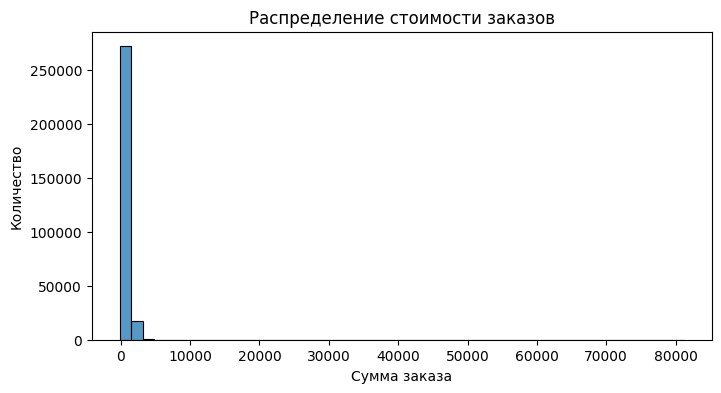

In [42]:
plt.figure(figsize=(8, 4))

sns.histplot(data=df, x='revenue_rub', bins=50)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

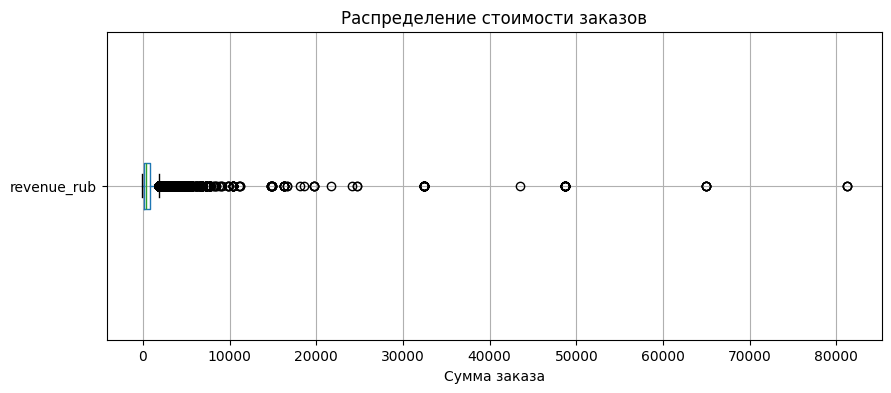

In [43]:
plt.figure(figsize=(10, 4))

df.boxplot(column='revenue_rub', vert=False)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')

plt.show()

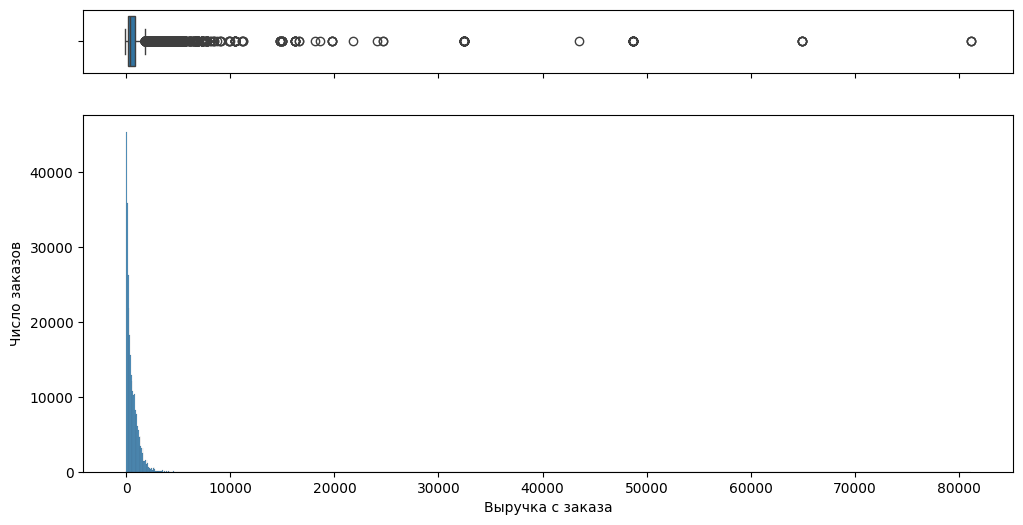

In [44]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12, 6), gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(x=df["revenue_rub"], orient="h", ax=ax_box)
sns.histplot(data=df, x="revenue_rub", ax=ax_hist)
 
ax_box.set(xlabel='Выручка с заказа')
ax_hist.set(xlabel='Выручка с заказа')
ax_hist.set(ylabel='Число заказов')
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Диаграмма размаха явно отобразила выбросы. Это могут быть оптовые покупки, ошибки в данных и корпоративные заказы, которые искажают статистические показатели. Отфильтруем по 99 персентилю
</div>

In [45]:
percentile_99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= percentile_99]

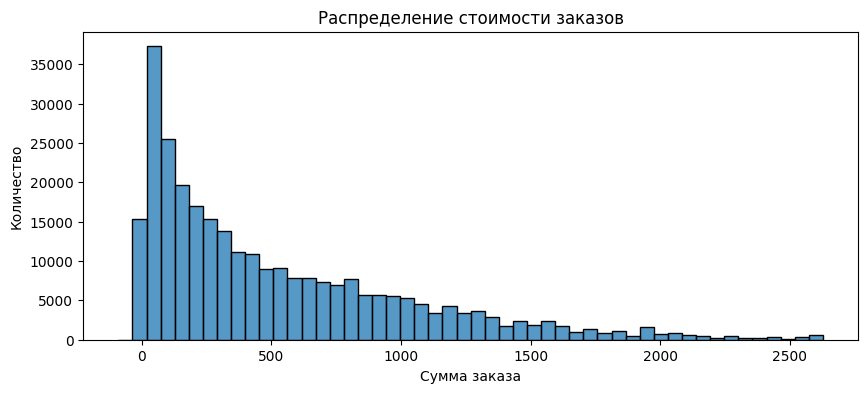

In [46]:
plt.figure(figsize=(10, 4))

sns.histplot(data=df_filtered, x='revenue_rub', bins=50)

plt.title('Распределение стоимости заказов')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

In [47]:
df['revenue_rub'].describe()

count    290571.000000
mean        555.585977
std         875.528775
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [48]:
df_filtered['revenue_rub'].describe()

count    287746.000000
mean        518.038133
std         511.948996
min         -90.760000
25%         111.860000
50%         343.955000
75%         788.660000
max        2628.421739
Name: revenue_rub, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
После фильтрации по 99 персентилю гистограмма наглядно отобразила распределение стоимости заказов. В основном стоимость заказа не превышает 500 руб. Так же видим наличие отрицательных значения стоимости.
</div>

In [49]:
df = df_filtered

In [50]:
df_negative_revenue = df[df['revenue_rub'] < 0]

In [51]:
df_negative_revenue['revenue_rub'].describe()

count    381.000000
mean      -2.492362
std        5.065072
min      -90.760000
25%       -3.450000
50%       -1.580000
75%       -0.650000
max       -0.010000
Name: revenue_rub, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Всего заказов отрицательной стоимостью 381. Это могут быть возвраты, которые не должны влиять на текущий анализ, поэтому думаю правильно будет отфильтровать такие заказы
</div>

In [52]:
df = df[df['revenue_rub'] >= 0]

In [53]:
df[df['revenue_rub'] < 0].shape

(0, 16)

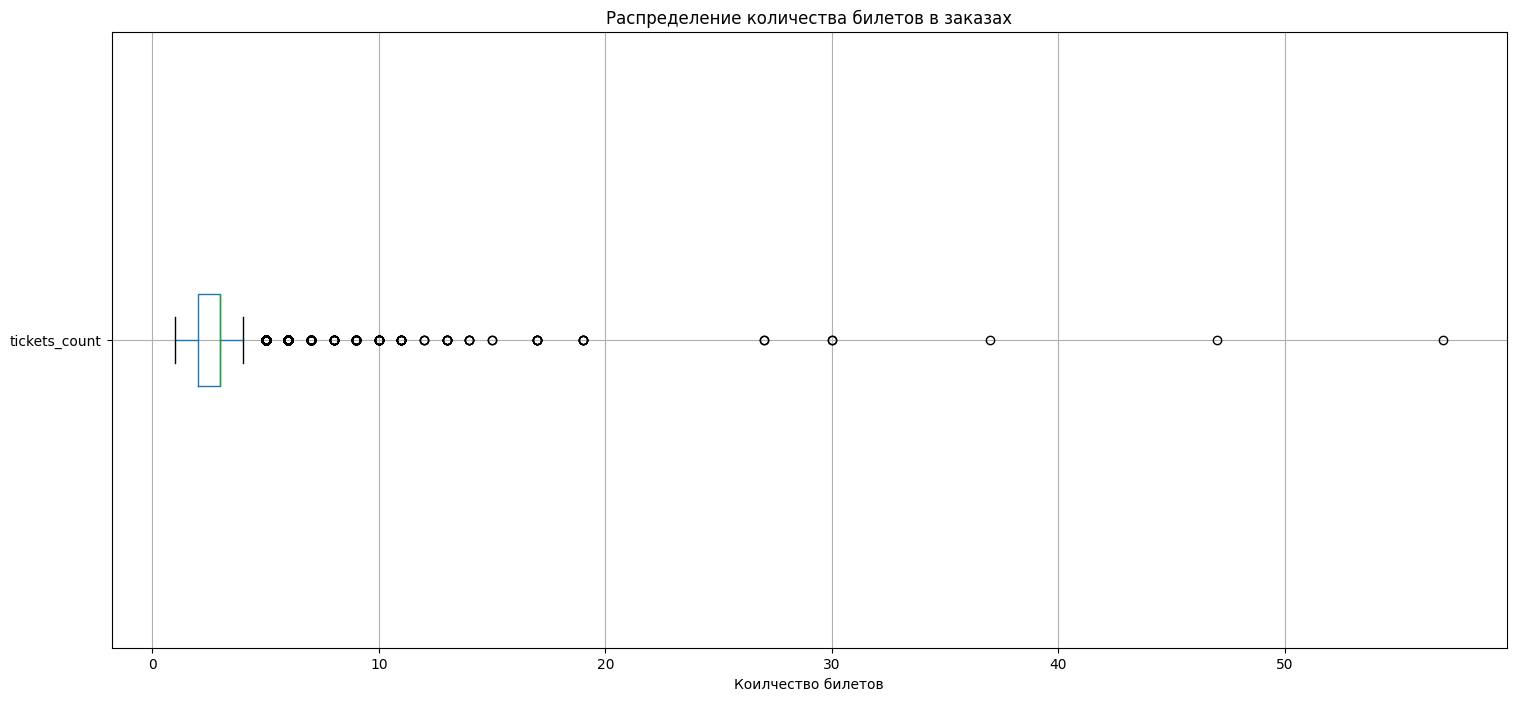

In [54]:
plt.figure(figsize=(18, 8))

df.boxplot(column='tickets_count', vert=False)

plt.title('Распределение количества билетов в заказах')
plt.xlabel('Коилчество билетов')

plt.show()

In [55]:
df['tickets_count'].value_counts()

tickets_count
3     91591
2     83524
4     53622
1     41655
5     12850
6      3943
7        58
9        38
10       19
8        18
11       13
13        7
17        6
19        5
14        4
12        3
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
1-6 билетов - это абсолютное большинство заказов, а значения 10+ являются экстремальными (оптовые закупки, ошибки в данных). Отфильтруем по количеству билетов менее 10
</div>

In [56]:
df_tickets = df[df['tickets_count'] < 10]

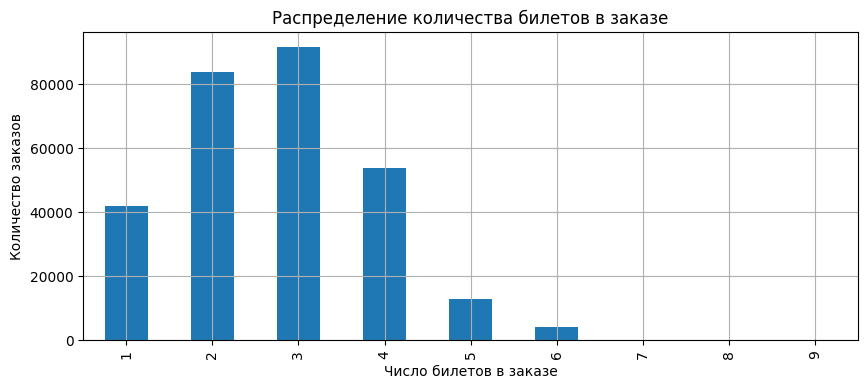

In [57]:
plt.figure(figsize=(10, 4))

df_tickets['tickets_count'].value_counts().sort_index().plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Распределение количества билетов в заказе'
)

plt.grid()
plt.xlabel('Число билетов в заказе')
plt.ylabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По столбчатой диаграмме видим, что наибоее часто заказы содержат по 3 или 2 билета
</div>

In [58]:
print(df.shape)
print(df_tickets.shape)
print(df.shape[0] - df_tickets.shape[0])

(287365, 16)
(287299, 16)
66


<div style="font-size: 18px; line-height: 1.5; color: blue;">
66 заказов из 287365 с количеством билетов от 10 было убрано
</div>

In [59]:
df = df_tickets

<div style="font-size: 24px; line-height: 1.5; color: blue;">
Вывод по предобработке данных
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>Добавлен столбец revenue_rub, т.е. имеющийся стобец revenue содержал разные значения по валюте</li>
<li>Отфильтрованы заказы по выбросам по стоимости и по количеству билетов - убрано 2917 записей (около 1%)</li>
<li>Нормализованы столбцы city_name, region_name, event_type_main, service_name</li>
<li>Получена информация по распределению revenue_rub и tickets_count</li>
</ul>
</div>

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Сортируем чтобы далее использовать агрегацию first
</div>

In [60]:
df_sorted = df.sort_values(['user_id', 'order_dt'])

In [61]:
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'), # Билетный партнер первого заказа
    first_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'nunique'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'), # Среднее количество билетов в заказе
    avg_days_between_orders=('days_since_prev', 'mean')     # Среднее время между заказами (исключая NaN)
).reset_index()

In [62]:
user_profile = user_profile.assign(
    is_two=lambda x: (x['total_orders'] >= 2).astype(int),
    is_five=lambda x: (x['total_orders'] >= 5).astype(int)
)

In [63]:
display(user_profile.shape)
display(user_profile.head())

(21835, 13)

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Проверим правильность агрегации
</div>

In [64]:
# Выбираем нескольких случайных пользователей для детальной проверки
sample_users = user_profile['user_id'].sample(5, random_state=42)

for user_id in sample_users:
    print(f"\n🔍 Проверка пользователя {user_id}:")
    print("-" * 50)
    
    # Данные из профиля
    profile_data = user_profile[user_profile['user_id'] == user_id].iloc[0]
    
    # Исходные данные пользователя
    user_orders = df[df['user_id'] == user_id].sort_values('order_dt')
    
    print(f"Из профиля:")
    print(f"  • Первый заказ: {profile_data['first_order_date']}")
    print(f"  • Последний заказ: {profile_data['last_order_date']}")
    print(f"  • Всего заказов: {profile_data['total_orders']}")
    print(f"  • Первое устройство: {profile_data['first_device']}")
    print(f"  • Первый регион: {profile_data['first_region']}")
    
    print(f"\nИз исходных данных:")
    print(f"  • Фактический первый заказ: {user_orders['order_dt'].min()}")
    print(f"  • Фактический последний заказ: {user_orders['order_dt'].max()}")
    print(f"  • Фактическое количество заказов: {user_orders['order_id'].nunique()}")
    print(f"  • Фактическое первое устройство: {user_orders.iloc[0]['device_type_canonical']}")
    print(f"  • Фактический первый регион: {user_orders.iloc[0]['region_name']}")
    
    # Проверка совпадения
    checks = [
        profile_data['first_order_date'] == user_orders['order_dt'].min(),
        profile_data['last_order_date'] == user_orders['order_dt'].max(),
        profile_data['total_orders'] == user_orders['order_id'].nunique(),
        profile_data['first_device'] == user_orders.iloc[0]['device_type_canonical']
    ]
    
    if all(checks):
        print("✅ Все данные совпадают")
    else:
        print("❌ Есть расхождения!")



🔍 Проверка пользователя 1c63c7d257708b7:
--------------------------------------------------
Из профиля:
  • Первый заказ: 2024-10-15 00:00:00
  • Последний заказ: 2024-10-15 00:00:00
  • Всего заказов: 1
  • Первое устройство: mobile
  • Первый регион: каменевский регион

Из исходных данных:
  • Фактический первый заказ: 2024-10-15 00:00:00
  • Фактический последний заказ: 2024-10-15 00:00:00
  • Фактическое количество заказов: 1
  • Фактическое первое устройство: mobile
  • Фактический первый регион: каменевский регион
✅ Все данные совпадают

🔍 Проверка пользователя 9722b318385f6d1:
--------------------------------------------------
Из профиля:
  • Первый заказ: 2024-06-10 00:00:00
  • Последний заказ: 2024-06-10 00:00:00
  • Всего заказов: 6
  • Первое устройство: mobile
  • Первый регион: шанырский регион

Из исходных данных:
  • Фактический первый заказ: 2024-06-10 00:00:00
  • Фактический последний заказ: 2024-06-10 00:00:00
  • Фактическое количество заказов: 6
  • Фактическое п

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [65]:
total_users = len(user_profile)
print(f"Общее число пользователей в выборке: {total_users}")

total_revenue = (user_profile['avg_revenue_rub'] * user_profile['total_orders']).sum()
total_orders = user_profile['total_orders'].sum()
avg_revenue_per_order = total_revenue / total_orders
print(f"Средняя выручка с одного заказа (общая): {avg_revenue_per_order:.2f} руб.")

users_two_plus = user_profile['is_two'].sum()
ratio_two_plus = users_two_plus / total_users
print(f"Доля пользователей с 2+ заказами: {ratio_two_plus:.2%} ({users_two_plus} из {total_users})")

users_five_plus = user_profile['is_five'].sum()
ratio_five_plus = users_five_plus / total_users
print(f"Доля пользователей с 5+ заказами: {ratio_five_plus:.2%} ({users_five_plus} из {total_users})")

Общее число пользователей в выборке: 21835
Средняя выручка с одного заказа (общая): 518.61 руб.
Доля пользователей с 2+ заказами: 61.70% (13473 из 21835)
Доля пользователей с 5+ заказами: 28.99% (6330 из 21835)


In [66]:
user_profile['total_orders'].describe()

count    21835.000000
mean        13.157728
std        121.525371
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10164.000000
Name: total_orders, dtype: float64

In [67]:
user_profile[user_profile['total_orders'] > 100]['total_orders'].describe()

count      352.000000
mean       464.846591
std        838.751045
min        101.000000
25%        129.750000
50%        194.000000
75%        444.000000
max      10164.000000
Name: total_orders, dtype: float64

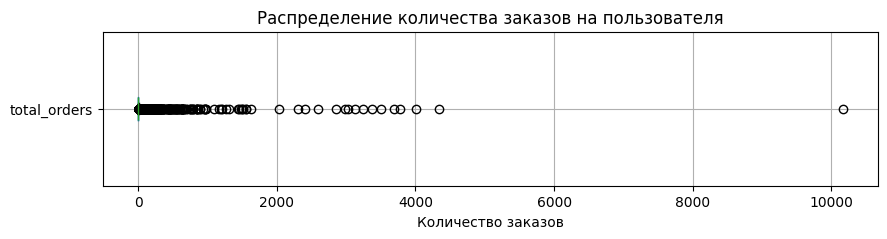

In [68]:
plt.figure(figsize=(10, 2))

user_profile.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По полученной информации о количестве заказов на пользователя видим большое стандартное отклонение (121) по сравнению со средним значением (13) 
и большое количество выбросов на диаграмме размаха. Думаю надо пробовать фильтровать данные, для начала по 99-му персентилю
</div>

In [69]:
percentile_99 = user_profile['total_orders'].quantile(0.99)
user_profile_total_orders_99 = user_profile[user_profile['total_orders'] <= percentile_99]

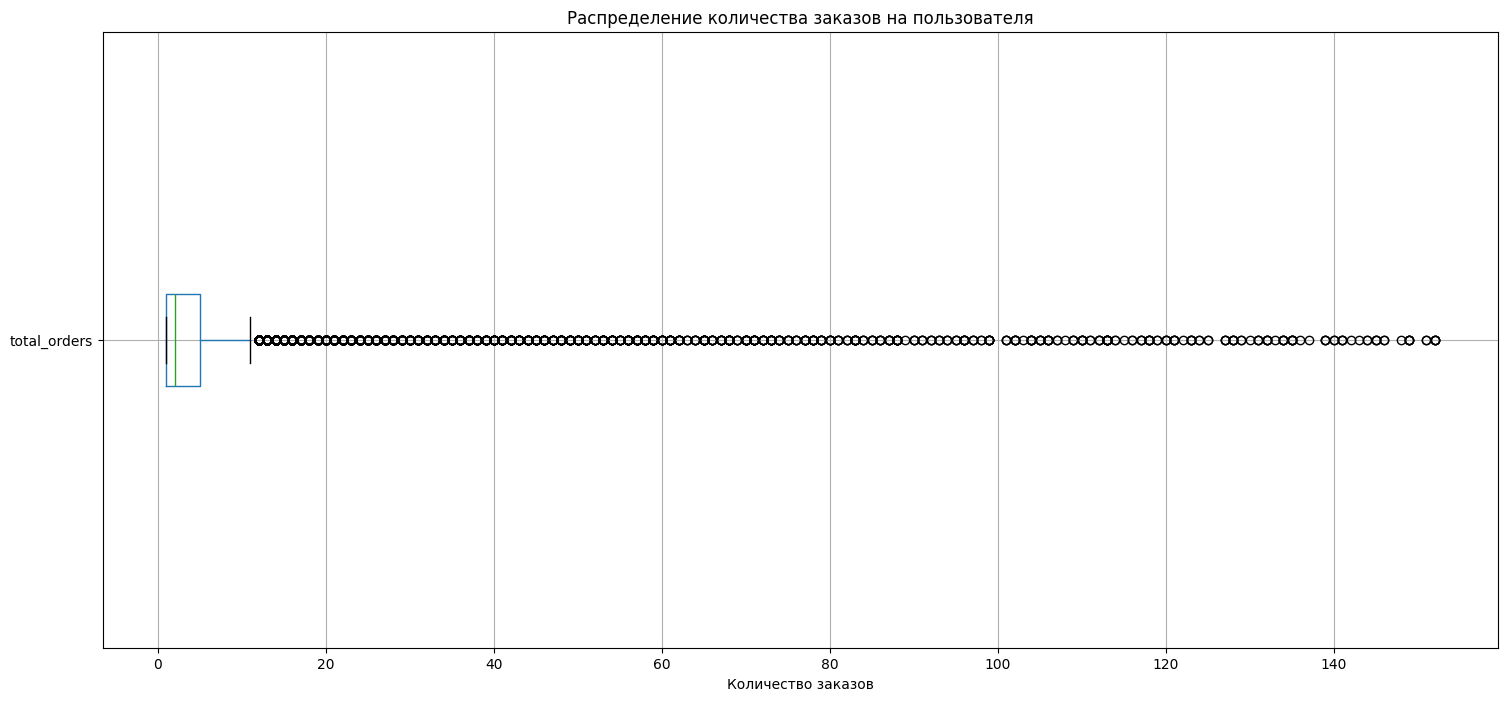

In [70]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_99.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Все еще достаточно большое количество выбросов и ящик не так выражен на диаграмме
</div>

In [71]:
percentile_95 = user_profile['total_orders'].quantile(0.95)
user_profile_total_orders_95 = user_profile[user_profile['total_orders'] <= percentile_95]

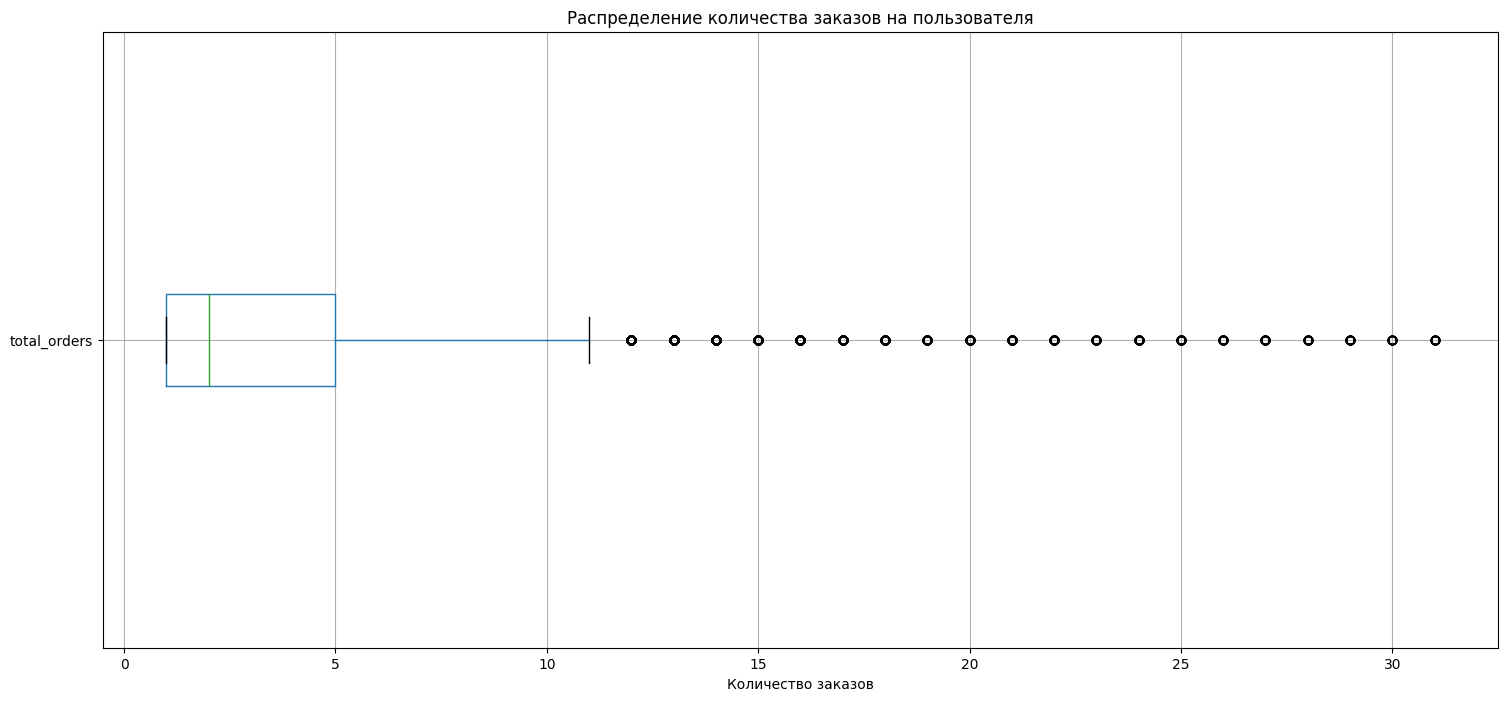

In [72]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_95.boxplot(column='total_orders', vert=False)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')

plt.show()

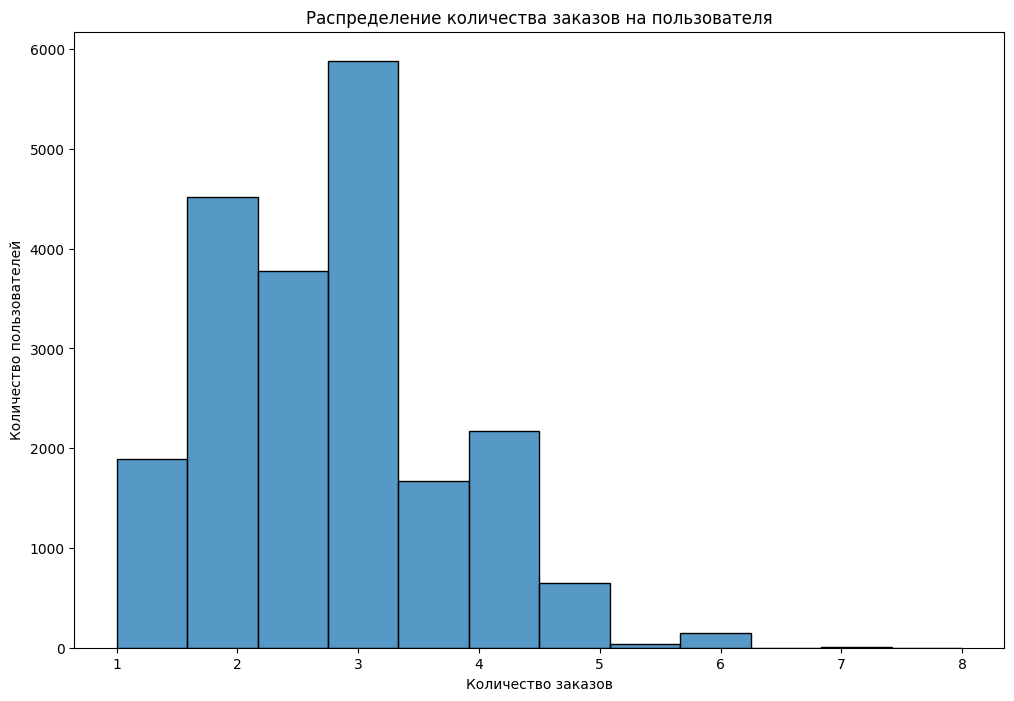

In [73]:
plt.figure(figsize=(12, 8))

sns.histplot(data=user_profile_total_orders_95, x='avg_tickets', bins=12)

plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

In [74]:
user_profile['avg_tickets'].describe()

count    21835.000000
mean         2.742083
std          0.906086
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max          8.000000
Name: avg_tickets, dtype: float64

In [75]:
user_profile_total_orders_95['avg_tickets'].describe()

count    20745.000000
mean         2.742609
std          0.927440
min          1.000000
25%          2.000000
50%          2.750000
75%          3.153846
max          8.000000
Name: avg_tickets, dtype: float64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Характеристики среднего количества билетов практически не изменились после фильтрации
</div>

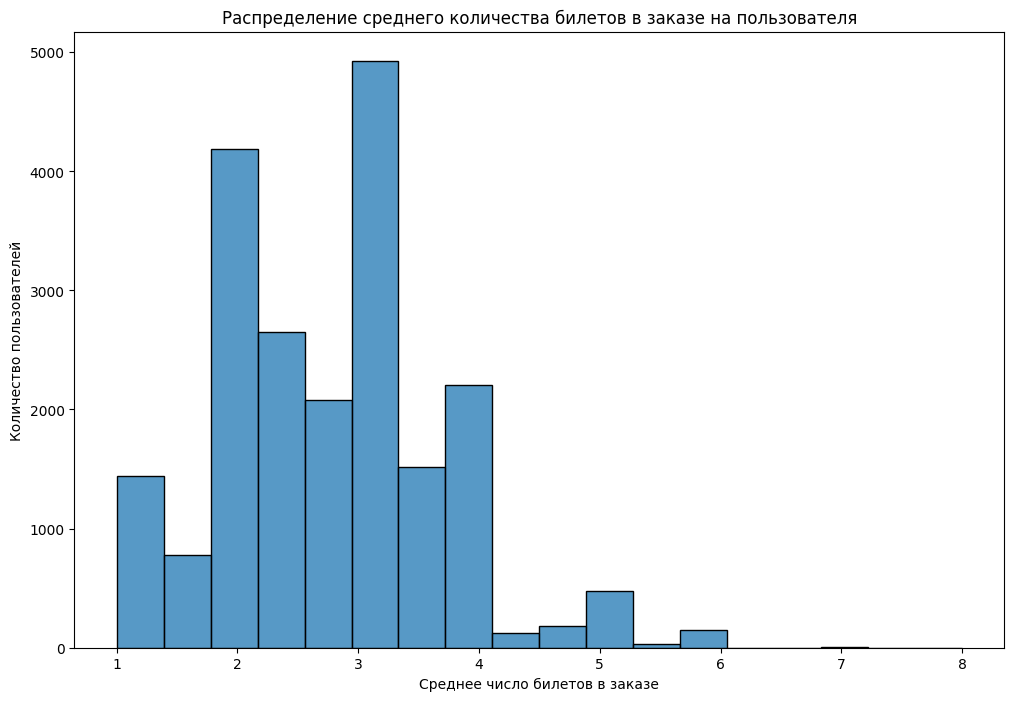

In [76]:
plt.figure(figsize=(12, 8))

sns.histplot(data=user_profile_total_orders_95, x='avg_tickets', bins=18)

plt.title('Распределение среднего количества билетов в заказе на пользователя')
plt.xlabel('Среднее число билетов в заказе')
plt.ylabel('Количество пользователей')
plt.show()

In [77]:
repeat_buyers = user_profile[user_profile['total_orders'] > 1]
repeat_buyers['avg_days_between_orders'].describe()

count    13473.000000
mean        15.820907
std         22.238295
min          0.000000
25%          1.000000
50%          8.000000
75%         20.333333
max        148.000000
Name: avg_days_between_orders, dtype: float64

In [78]:
repeat_buyers = user_profile_total_orders_95[user_profile_total_orders_95['total_orders'] > 1]
repeat_buyers['avg_days_between_orders'].describe()

count    12383.000000
mean        17.023590
std         22.804690
min          0.000000
25%          1.000000
50%          9.466667
75%         22.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64

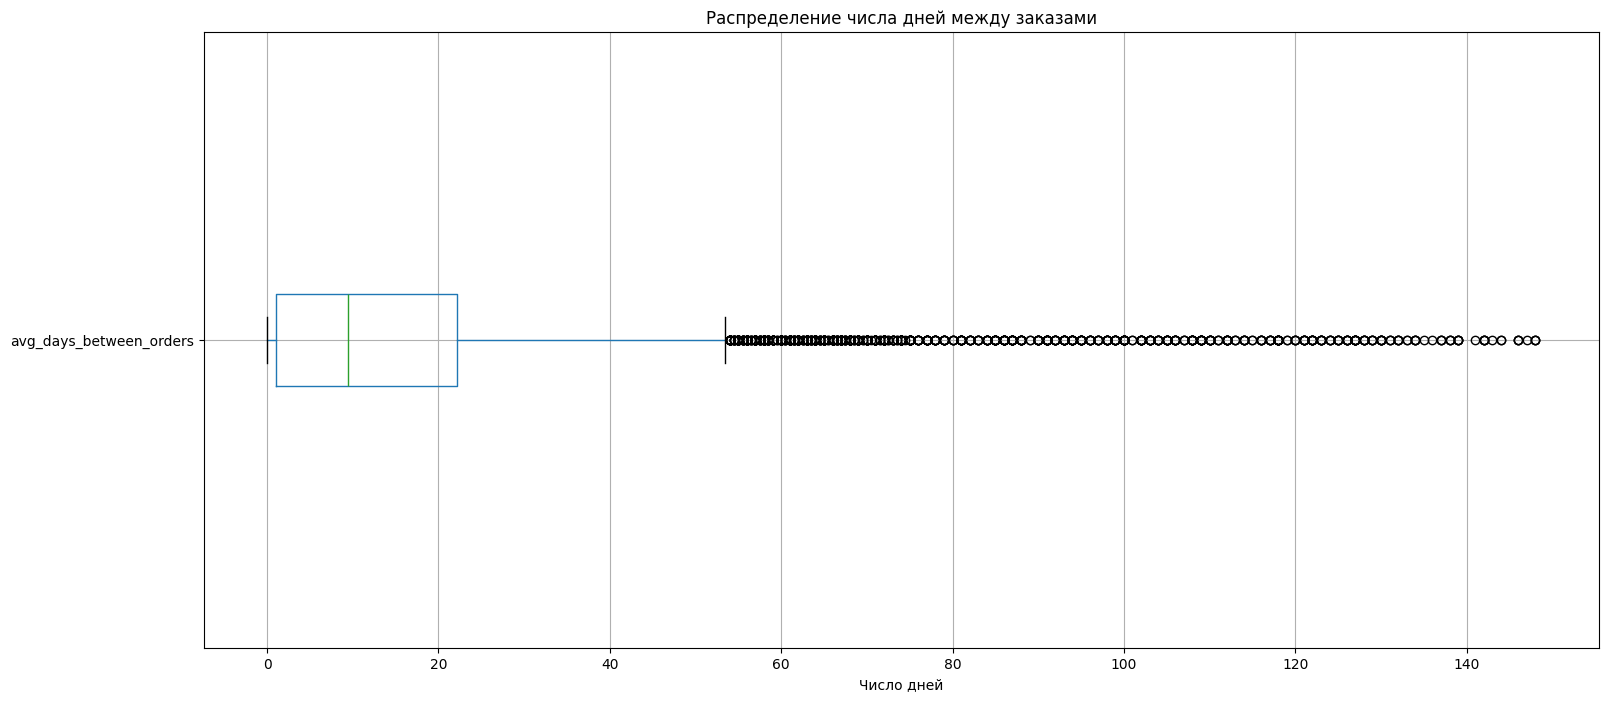

In [79]:
plt.figure(figsize=(18, 8))

user_profile_total_orders_95.boxplot(column='avg_days_between_orders', vert=False)

plt.title('Распределение числа дней между заказами')
plt.xlabel('Число дней')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Для показателей среднего количества дней между заказами стандартное отклонение больше среднего значения, однако не думаю что пользователи с большим количеством дней не могут представлять нормальные данные, поэтому не буду фильтровать
</div>

In [80]:
print(user_profile_total_orders_95.shape)

(20745, 13)


In [81]:
display(user_profile.shape)
display(user_profile_total_orders_95.shape)
display(user_profile.shape[0] - user_profile_total_orders_95.shape[0])

(21835, 13)

(20745, 13)

1090

In [82]:
user_profile = user_profile_total_orders_95

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Отфильтровали около 5% данных чтобы приблизить значения стандартных отклонений и средних значений для показателей количества заказов пользователей
</div>

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [83]:
#Группировка по типу первого мероприятия
event_type_groups = user_profile.groupby('first_genre').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100)
).round(2).sort_values('total_users', ascending=False)
event_type_groups

,total_users,percentage
first_genre,,
концерты,9196,44.33
другое,5148,24.82
театр,4076,19.65
стендап,1073,5.17
спорт,765,3.69
выставки,395,1.90
ёлки,92,0.44


<div style="font-size: 18px; line-height: 1.5; color: blue;">
При группировке по типу первого мероприятия выделяются категории "концерты", "другое" и "театр"
</div>

In [84]:
#Группировка по типу устройства с которого совершена первая покупка
device_groups = user_profile.groupby('first_device').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100)
).round(2).sort_values('total_users', ascending=False)
device_groups

,total_users,percentage
first_device,,
mobile,17184,82.83
desktop,3561,17.17


<div style="font-size: 18px; line-height: 1.5; color: blue;">
В основном первый заказ делают с мобильного устройства - почти 83% пользователей
</div>

In [85]:
#Группировка по региону проведения мероприятия из первого заказа
region_groups = user_profile.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100)
).round(2).sort_values('total_users', ascending=False)
region_groups.head()

,total_users,percentage
first_region,,
каменевский регион,6779,32.68
североярская область,3598,17.34
широковская область,1189,5.73
озернинский край,659,3.18
малиновоярский округ,511,2.46


<div style="font-size: 18px; line-height: 1.5; color: blue;">
А из регонов для первого мероприятия выделяются 'каменевский регион' - 32.68% и 'североярская область' - 17.34%
</div>

In [86]:
#Группировка по билетному оператору, продавшему билеты на первый заказ
partner_groups = user_profile.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100)
).round(2).sort_values('total_users', ascending=False)
partner_groups.head()

,total_users,percentage
first_partner,,
билеты без проблем,4947,23.85
мой билет,2853,13.75
лови билет!,2721,13.12
билеты в руки,2418,11.66
облачко,2108,10.16


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Основным поставщиком билетов является 'билеты без проблем' - 23.85% что почти в 2 раза больше чем у оператора на втором месте
</div>

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [87]:
#Группировка по типу первого мероприятия с отображением процента пользователей с повторными заказами
genre_gr = user_profile.groupby('first_genre').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
genre_gr['repeat_ratio'] = (genre_gr['users_with_2plus_orders'] / genre_gr['total_users'] * 100).round(2)
genre_gr = genre_gr.sort_values('repeat_ratio', ascending=False)

genre_gr

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_genre,,,,
выставки,395,1.90,247,62.53
театр,4076,19.65,2524,61.92
концерты,9196,44.33,5544,60.29
стендап,1073,5.17,639,59.55
другое,5148,24.82,2965,57.60
ёлки,92,0.44,50,54.35
спорт,765,3.69,414,54.12


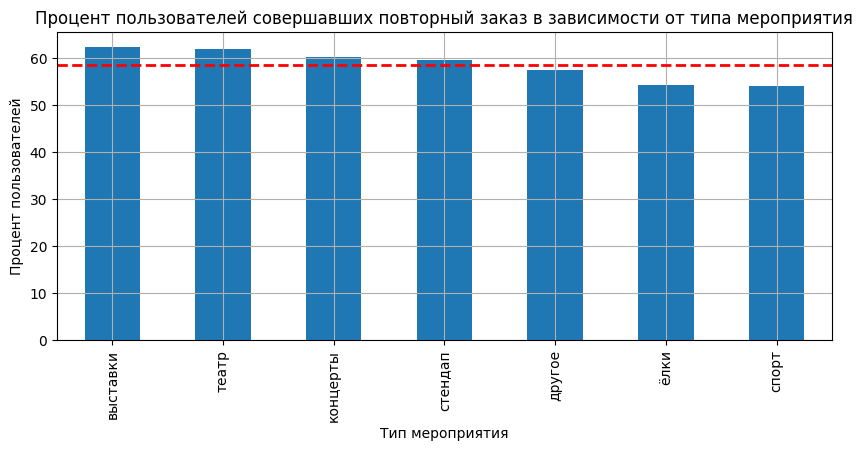

In [88]:
plt.figure(figsize=(10, 4))

genre_gr['repeat_ratio'].plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от типа мероприятия'
)

plt.grid()
plt.xlabel('Тип мероприятия')
plt.ylabel('Процент пользователей')
plt.axhline(y=genre_gr['repeat_ratio'].mean(), color='red', linestyle='--', linewidth=2)

plt.show()

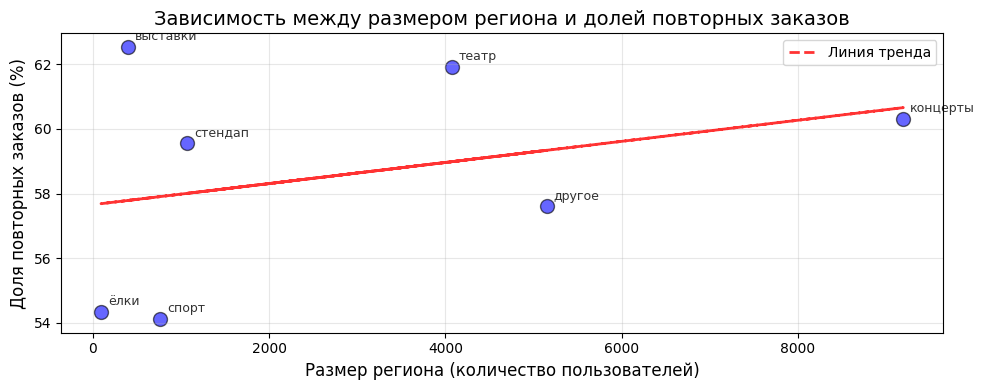

In [89]:
plt.figure(figsize=(10, 4))

plt.scatter(genre_gr['total_users'], genre_gr['repeat_ratio'], 
           alpha=0.6, s=100, color='blue', edgecolors='black')

# Добавляем подписи для крупнейших регионов
top_regions = genre_gr.sort_values(by='total_users').head(10)  # 10 крупнейших регионов
for idx, row in top_regions.iterrows():
    plt.annotate(row.name, 
                (row['total_users'], row['repeat_ratio']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

plt.xlabel('Размер региона (количество пользователей)', fontsize=12)
plt.ylabel('Доля повторных заказов (%)', fontsize=12)
plt.title('Зависимость между размером региона и долей повторных заказов', fontsize=14)
plt.grid(True, alpha=0.3)

# Добавляем линию тренда
z = np.polyfit(genre_gr['total_users'], genre_gr['repeat_ratio'], 1)
p = np.poly1d(z)
plt.plot(genre_gr['total_users'], p(genre_gr['total_users']), 
         "r--", alpha=0.8, linewidth=2, label='Линия тренда')

plt.legend()
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Кажется можно выделить сегмент 'театр' с небольшим отрывом и достаточно большим количетвом пользователей
</div>

In [90]:
#Группировка по типу устройства с которого совершена первая покупка с отображением процента пользователей с повторными заказами
device_gr = user_profile.groupby('first_device').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
device_gr['repeat_ratio'] = (device_gr['users_with_2plus_orders'] / device_gr['total_users'] * 100).round(2)
device_gr = device_gr.sort_values('repeat_ratio', ascending=False)

device_gr

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_device,,,,
desktop,3561,17.17,2219,62.31
mobile,17184,82.83,10164,59.15


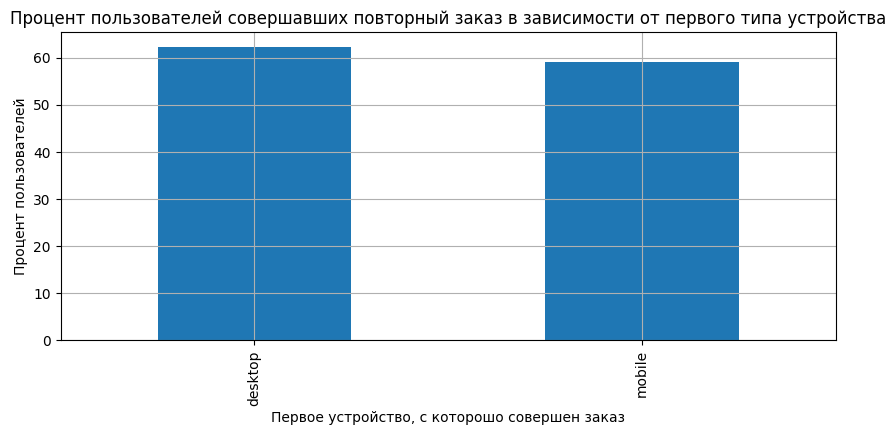

In [91]:
plt.figure(figsize=(10, 4))

device_gr['repeat_ratio'].plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от первого типа устройства'
)

plt.grid()
plt.xlabel('Первое устройство, с которошо совершен заказ')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
С компьютера чуть выше вероятность совершения повтоного заказа - 62% против 59% у мобильных устройств, но кажется в целом незначительно, учитывая еще отличающийся размер аудитории в сегментах
</div>

In [92]:
#Группировка по региону проведения мероприятия из первого заказа с отображением процента пользователей с повторными заказами
region_gr = user_profile.groupby('first_region').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
region_gr = region_gr[region_gr['percentage'] > 2]
region_gr['repeat_ratio'] = (region_gr['users_with_2plus_orders'] / region_gr['total_users'] * 100).round(2)
region_gr = region_gr.sort_values('repeat_ratio', ascending=False)

region_gr

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_region,,,,
шанырский регион,461,2.22,297,64.43
светополянский округ,439,2.12,282,64.24
широковская область,1189,5.73,754,63.41
североярская область,3598,17.34,2235,62.12
речиновская область,419,2.02,258,61.58
каменевский регион,6779,32.68,4114,60.69
травяная область,466,2.25,278,59.66
малиновоярский округ,511,2.46,279,54.60
озернинский край,659,3.18,357,54.17


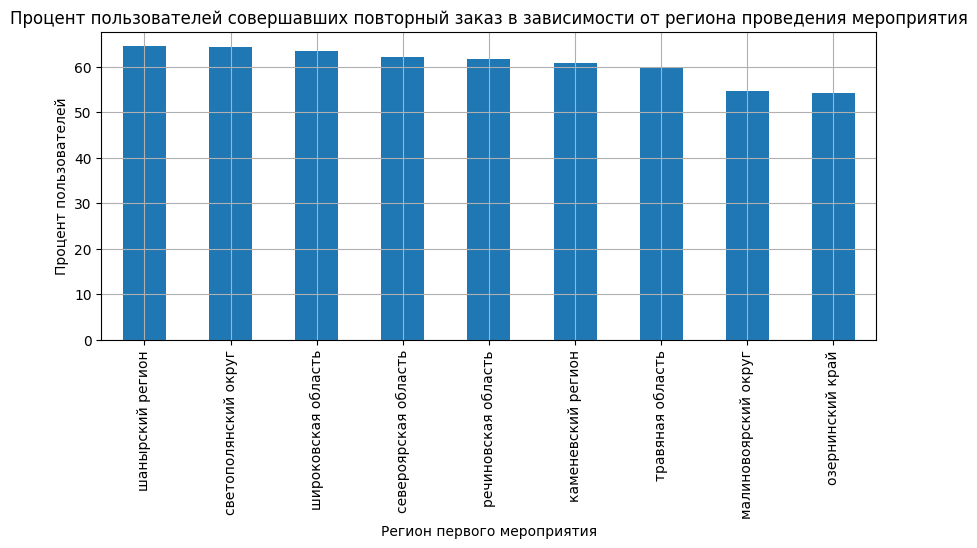

In [93]:
plt.figure(figsize=(10, 4))

region_gr['repeat_ratio'].head(10).sort_values(ascending=False).plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от региона проведения мероприятия'
)

plt.grid()
plt.xlabel('Регион первого мероприятия')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По типу региона есть лидеры где более 63% пользователей сделали повторный заказ - это 'шанырский регион' 'светополянский округ' и 'широковская область	'
</div>

In [94]:
#Группировка по билетному оператору, продавшему билеты на первый заказ с отображением процента пользователей с повторными заказами
partner_gr = user_profile.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
partner_gr = partner_gr[partner_gr['percentage'] > 1]
partner_gr['repeat_ratio'] = (partner_gr['users_with_2plus_orders'] / partner_gr['total_users'] * 100).round(2)
partner_gr = partner_gr.sort_values('repeat_ratio', ascending=False)

partner_gr

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_partner,,,,
край билетов,438,2.11,280,63.93
дом культуры,333,1.61,207,62.16
весь в билетах,1237,5.96,760,61.44
билеты в руки,2418,11.66,1466,60.63
облачко,2108,10.16,1264,59.96
прачечная,543,2.62,325,59.85
лови билет!,2721,13.12,1623,59.65
лучшие билеты,1128,5.44,671,59.49
мой билет,2853,13.75,1690,59.24


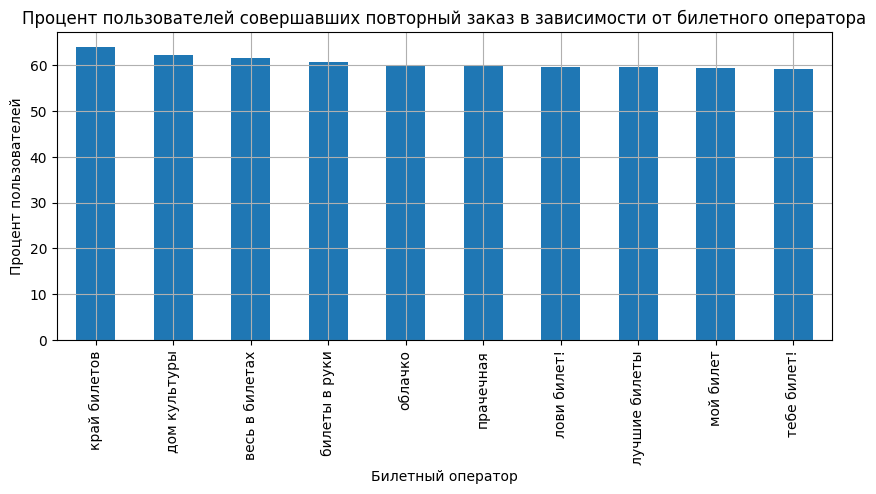

In [95]:
plt.figure(figsize=(10, 4))

partner_gr['repeat_ratio'].head(10).sort_values(ascending=False).plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Процент пользователей совершавших повторный заказ в зависимости от билетного оператора'
)

plt.grid()
plt.xlabel('Билетный оператор')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По билетным операторам лидеры где более 62% пользователей сделали повторный заказ это 'край билетов' и 'дом культуры'. Так же можно попробовать выявить проблемных операторов с самым низким процентом
</div>

In [96]:
#Группировка по билетному оператору, продавшему билеты на первый заказ с отображением процента пользователей с повторными заказами
partner_bad = user_profile.groupby('first_partner').agg(
    total_users=('user_id', 'count'),
    percentage=('user_id', lambda x: len(x) / len(user_profile) * 100),
    users_with_2plus_orders=('is_two', 'sum')
).round(2)
partner_bad = partner_bad[partner_bad['percentage'] > 0.1]
partner_bad['repeat_ratio'] = (partner_bad['users_with_2plus_orders'] / partner_bad['total_users'] * 100).round(2)
partner_bad = partner_bad.sort_values('repeat_ratio', ascending=True)

partner_bad.head()

,total_users,percentage,users_with_2plus_orders,repeat_ratio
first_partner,,,,
радио ticket,35,0.17,14,40.00
телебилет,28,0.13,13,46.43
яблоко,308,1.48,160,51.95
быстробилет,157,0.76,91,57.96
за билетом!,199,0.96,116,58.29


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Тут выделяется 'яблоко' с аудиторией 160 и 52%, что ниже средних значений, но в целом аудитория маленькая
</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Гипотезу 1 отклоняем, т. к. пользователей купивших повторный билет после спорта - 54.12%, а после концента 60.29%
</div>

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гипотезе 2 так же не получается сделать однозначный вывод, т.к. есть регионы с меньшей аудиторией, но бОльшим процентом покупки повторного билета
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [97]:
single_order_users = user_profile[user_profile['total_orders'] == 1]
repeat_users = user_profile[user_profile['total_orders'] >= 2]

In [98]:
print(f"Пользователей с 1 заказом: {len(single_order_users):,}")
print(f"Пользователей с 2+ заказами: {len(repeat_users):,}")

print(f"\nСредняя выручка с заказа:")
print(f"  - 1 заказ: {single_order_users['avg_revenue_rub'].mean():.2f} руб.")
print(f"  - 2+ заказов: {repeat_users['avg_revenue_rub'].mean():.2f} руб.")

print(f"\nМедианная выручка с заказа:")
print(f"  - 1 заказ: {single_order_users['avg_revenue_rub'].median():.2f} руб.")
print(f"  - 2+ заказов: {repeat_users['avg_revenue_rub'].median():.2f} руб.")

Пользователей с 1 заказом: 8,362
Пользователей с 2+ заказами: 12,383

Средняя выручка с заказа:
  - 1 заказ: 545.66 руб.
  - 2+ заказов: 548.29 руб.

Медианная выручка с заказа:
  - 1 заказ: 378.73 руб.
  - 2+ заказов: 494.77 руб.


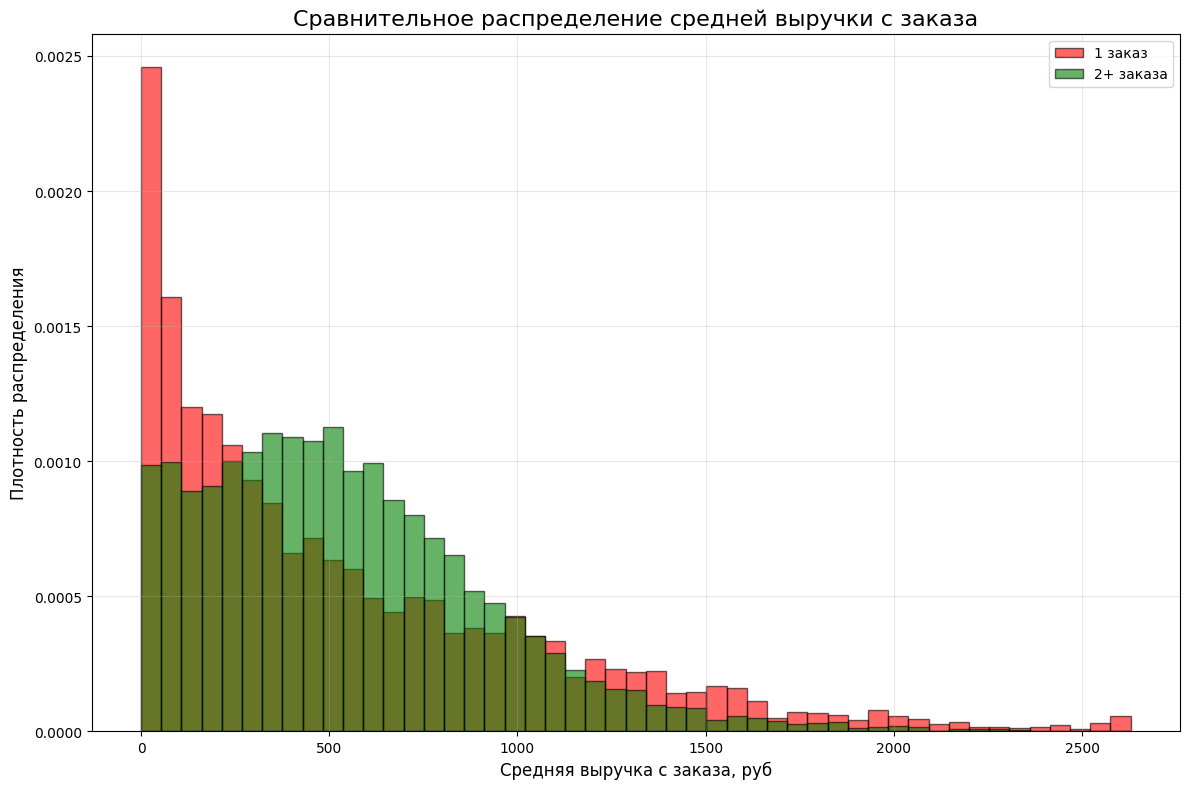

In [99]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(single_order_users['avg_revenue_rub'].min(), repeat_users['avg_revenue_rub'].min()),
    max(single_order_users['avg_revenue_rub'].max(), repeat_users['avg_revenue_rub'].max()),
    50
)

plt.hist(single_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='red', 
         label='1 заказ', edgecolor='black', density=True)
plt.hist(repeat_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='green', 
         label='2+ заказа', edgecolor='black', density=True)

plt.title('Сравнительное распределение средней выручки с заказа', fontsize=16)
plt.xlabel('Средняя выручка с заказа, руб', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гистограммер распределения средней выручки для клиентов с одним заказом и клиентов с множеством заказов можно заметить, что у клиентов с одним заказом разброс значений больше, преобладают более дешевые билеты, в то время как клиенты с множеством заказов имеют большую сконцентрированность вокруг среднего
</div>

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [100]:
two_four_order_users = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
five_order_users = user_profile[user_profile['total_orders'] >= 5]

In [101]:
print(f"Пользователей с 2-4 заказами: {len(two_four_order_users):,}")
print(f"Пользователей с 5+ заказами: {len(five_order_users):,}")

print(f"\nСредняя выручка с заказа:")
print(f"  - 2-4 заказа: {two_four_order_users['avg_revenue_rub'].mean():.2f} руб.")
print(f"  - 5+ заказов: {five_order_users['avg_revenue_rub'].mean():.2f} руб.")

print(f"\nМедианная выручка с заказа:")
print(f"  - 2-4 заказа: {two_four_order_users['avg_revenue_rub'].median():.2f} руб.")
print(f"  - 5+ заказов: {five_order_users['avg_revenue_rub'].median():.2f} руб.")

Пользователей с 2-4 заказами: 7,143
Пользователей с 5+ заказами: 5,240

Средняя выручка с заказа:
  - 2-4 заказа: 552.21 руб.
  - 5+ заказов: 542.94 руб.

Медианная выручка с заказа:
  - 2-4 заказа: 472.16 руб.
  - 5+ заказов: 515.07 руб.


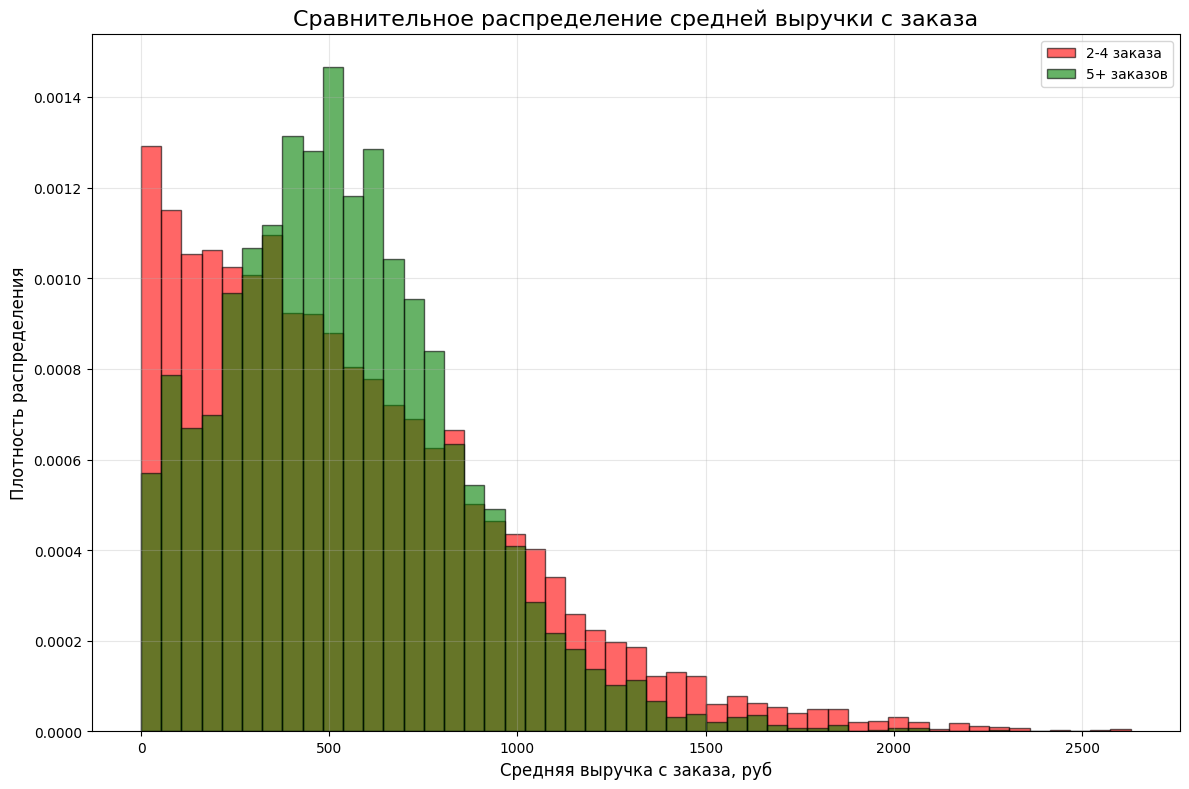

In [102]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(two_four_order_users['avg_revenue_rub'].min(), five_order_users['avg_revenue_rub'].min()),
    max(two_four_order_users['avg_revenue_rub'].max(), five_order_users['avg_revenue_rub'].max()),
    50
)

plt.hist(two_four_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='red', 
         label='2-4 заказа', edgecolor='black', density=True)
plt.hist(five_order_users['avg_revenue_rub'], bins=data_range, alpha=0.6, color='green', 
         label='5+ заказов', edgecolor='black', density=True)

plt.title('Сравнительное распределение средней выручки с заказа', fontsize=16)
plt.xlabel('Средняя выручка с заказа, руб', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Тут похожая картина - разброс выручки от пользователей с 2-4 заказами больше, нежели у пользователей с 5+ заказами
</div>

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [103]:
user_profile['ticket_segment'] = pd.cut(
    user_profile['avg_tickets'],
    bins=[1, 2, 3, 5, float('inf')],
    labels=['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов'],
    right=False
)

In [104]:
segment_analysis = user_profile.groupby('ticket_segment', observed=False).agg(
    total_users=('user_id', 'count'),
    users_with_2plus_orders=('is_two', 'sum'),
    avg_tickets=('avg_tickets', 'mean'),
    median_tickets=('avg_tickets', 'median')
).reset_index()

# Вычисляем доли
segment_analysis['percentage_of_total'] = (segment_analysis['total_users'] / len(user_profile) * 100).round(2)
segment_analysis['repeat_ratio'] = (segment_analysis['users_with_2plus_orders'] / segment_analysis['total_users'] * 100).round(2)

In [105]:
print("РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:")
for _, row in segment_analysis.iterrows():
    print(f"\n{row['ticket_segment']}:")
    print(f"  Пользователей: {row['total_users']:,} ({row['percentage_of_total']}%)")
    print(f"  Среднее количество билетов: {row['avg_tickets']:.2f}")
    print(f"  Медианное количество билетов: {row['median_tickets']:.2f}")
    print(f"  Пользователей с 2+ заказами: {row['users_with_2plus_orders']:,} ({row['repeat_ratio']}%)")

РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:

1-2 билета:
  Пользователей: 2,406 (11.6%)
  Среднее количество билетов: 1.27
  Медианное количество билетов: 1.00
  Пользователей с 2+ заказами: 1,231 (51.16%)

2-3 билета:
  Пользователей: 8,754 (42.2%)
  Среднее количество билетов: 2.30
  Медианное количество билетов: 2.25
  Пользователей с 2+ заказами: 6,246 (71.35%)

3-5 билетов:
  Пользователей: 8,930 (43.05%)
  Среднее количество билетов: 3.39
  Медианное количество билетов: 3.17
  Пользователей с 2+ заказами: 4,786 (53.59%)

5+ билетов:
  Пользователей: 655 (3.16%)
  Среднее количество билетов: 5.25
  Медианное количество билетов: 5.00
  Пользователей с 2+ заказами: 120 (18.32%)


<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>Основное число клиентов ~85% покупают от 2 до 5 билетов</li>
<li>Аномально малое количество повторных покупок у сегмента со средним числом билетов 5+</li>
<li>Высокий процент клиентов с повторными покупками у сегмента с 2-3 билетами (70.61%)</li>
</ul>
</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [106]:
user_profile['first_order_weekday'] = pd.to_datetime(user_profile['first_order_date']).dt.day_name()

In [107]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,3-5 билетов,Tuesday
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,2-3 билета,Saturday
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1-2 билета,Sunday


In [108]:
user_profile['first_order_weekday'].value_counts().sort_values(ascending=False)

first_order_weekday
Friday       3162
Saturday     3119
Thursday     3026
Tuesday      3024
Wednesday    2961
Monday       2813
Sunday       2640
Name: count, dtype: int64

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Наиболее часто новые клиенты делают заказ в пятницу и субботу
</div>

In [109]:
# Вычисляем лайфтайм (время с момента первой покупки)
current_date = pd.to_datetime(df['order_dt']).max()
user_profile['lifetime_days'] = (current_date - user_profile['first_order_date']).dt.days

In [110]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday,lifetime_days
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday,72
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,3-5 билетов,Tuesday,100
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,2-3 билета,Saturday,110
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday,77
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1-2 билета,Sunday,32


In [111]:
user_profile['lifetime_days'].describe()

count    20745.000000
mean        78.805688
std         47.093762
min          0.000000
25%         36.000000
50%         79.000000
75%        122.000000
max        152.000000
Name: lifetime_days, dtype: float64

In [112]:
lifetime_segments = [
    (user_profile['lifetime_days'] <= 30, '0-30 дней'),
    ((user_profile['lifetime_days'] > 30) & (user_profile['lifetime_days'] <= 90), '31-90 дней'),
    (user_profile['lifetime_days'] > 90, '90+ дней')
]

user_profile['lifetime_segment'] = np.select(
    [condition for condition, _ in lifetime_segments],
    [segment for _, segment in lifetime_segments],
    default='Другое'
)

In [113]:
lifetime_analysis = user_profile.groupby('lifetime_segment').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum'),
    avg_lifetime=('lifetime_days', 'mean')
).reset_index()

lifetime_analysis['repeat_ratio'] = (
    lifetime_analysis['repeat_users'] / lifetime_analysis['total_users'] * 100
).round(2)
lifetime_analysis['percentage_of_total'] = (lifetime_analysis['total_users'] / len(user_profile) * 100).round(2)

In [114]:
print(f"\nРаспределение по лайфтайму:")
for _, row in lifetime_analysis.iterrows():
    print(f"  {row['lifetime_segment']}: {row['total_users']} пользователей ({row['percentage_of_total']}%), "
          f"повторные: {row['repeat_ratio']}%")


Распределение по лайфтайму:
  0-30 дней: 4329 пользователей (20.87%), повторные: 37.51%
  31-90 дней: 7387 пользователей (35.61%), повторные: 55.5%
  90+ дней: 9029 пользователей (43.52%), повторные: 73.75%


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Логично, что у группы более старых пользователей наибольший процент повторных заказов
</div>

In [115]:
# Анализируем только пользователей с повторными покупками
repeat_buyers = user_profile[user_profile['total_orders'] >= 2]
repeat_buyers = repeat_buyers.copy()

In [116]:
interval_segments = [
    (repeat_buyers['avg_days_between_orders'] <= 3, '0-3 дня'),
    ((repeat_buyers['avg_days_between_orders'] > 3) & (repeat_buyers['avg_days_between_orders'] <= 7), '4-7 дней'),
    ((repeat_buyers['avg_days_between_orders'] > 7) & (repeat_buyers['avg_days_between_orders'] <= 14), '8-14 дней'),
    (repeat_buyers['avg_days_between_orders'] > 14, '15+ дней')
]
    
repeat_buyers['interval_segment'] = np.select(
    [condition for condition, _ in interval_segments],
    [segment for _, segment in interval_segments],
    default='Другое'
)

In [117]:
interval_analysis = repeat_buyers.groupby('interval_segment').agg(
    total_users=('user_id', 'count'),
    avg_interval=('avg_days_between_orders', 'mean'),
    avg_total_orders=('total_orders', 'mean')
).reset_index()

interval_analysis['percentage_of_repeaters'] = (interval_analysis['total_users'] / len(repeat_buyers) * 100).round(2)

In [118]:
print(f"\nРаспределение интервалов между покупками:")
for _, row in interval_analysis.iterrows():
    print(f"  {row['interval_segment']}: {row['total_users']:,} пользователей ({row['percentage_of_repeaters']}%), "
          f"ср. интервал: {row['avg_interval']:.1f} дней, ср. заказов: {row['avg_total_orders']:.1f}")


Распределение интервалов между покупками:
  0-3 дня: 3,652 пользователей (29.49%), ср. интервал: 0.4 дней, ср. заказов: 3.6
  15+ дней: 4,681 пользователей (37.8%), ср. интервал: 37.5 дней, ср. заказов: 4.0
  4-7 дней: 1,574 пользователей (12.71%), ср. интервал: 5.3 дней, ср. заказов: 13.7
  8-14 дней: 2,476 пользователей (20.0%), ср. интервал: 10.4 дней, ср. заказов: 8.9


<div style="font-size: 18px; line-height: 1.5; color: blue;">
Наибольшее число заказов у пользователей, которые делают их с интервалом 4-7 дней
</div>

In [119]:
weekday_analysis = user_profile.groupby('first_order_weekday').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')
)

In [120]:
weekday_analysis

,total_users,repeat_users
first_order_weekday,,
Friday,3162,1853
Monday,2813,1733
Saturday,3119,1883
Sunday,2640,1531
Thursday,3026,1764
Tuesday,3024,1814
Wednesday,2961,1805


In [121]:
weekday_analysis['repeat_ratio'] = (
    weekday_analysis['repeat_users'] / weekday_analysis['total_users'] * 100
).round(2)

In [122]:
weekday_analysis.sort_values('repeat_ratio', ascending=False)

,total_users,repeat_users,repeat_ratio
first_order_weekday,,,
Monday,2813,1733,61.61
Wednesday,2961,1805,60.96
Saturday,3119,1883,60.37
Tuesday,3024,1814,59.99
Friday,3162,1853,58.60
Thursday,3026,1764,58.29
Sunday,2640,1531,57.99


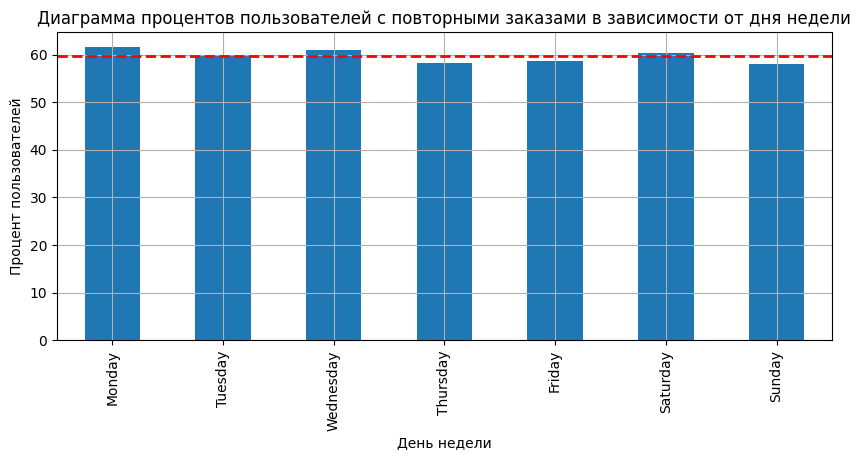

In [123]:
plt.figure(figsize=(10, 4))

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_analysis_sorted = weekday_analysis.reindex(weekday_order)
weekday_analysis_sorted['repeat_ratio'].plot(
               kind='bar',
               rot=90,
               legend=False,
               title=f'Диаграмма процентов пользователей с повторными заказами в зависимости от дня недели'
)

mean_value = weekday_analysis['repeat_ratio'].mean()
plt.axhline(y=mean_value, color='red', linestyle='--', linewidth=2, 
           label=f'Среднее: {mean_value:.1f}%')

plt.grid()
plt.xlabel('День недели')
plt.ylabel('Процент пользователей')

plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
Как мы видим наиболее выгодными днями недели являются понедельник и среда - если пользователь сделал свой первый заказ в эти дни, вероятность сделать повторный заказ выше
</div>

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [124]:
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

In [125]:
group_2_4['avg_days_between_orders'].describe()

count    7143.000000
mean       21.346668
std        28.514590
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between_orders, dtype: float64

In [126]:
group_2_4['avg_days_between_orders'].value_counts()

avg_days_between_orders
0.00      2446
1.00       157
2.00        94
3.00        81
8.00        74
          ... 
15.25        1
141.00       1
74.50        1
143.00       1
0.25         1
Name: count, Length: 327, dtype: int64

In [127]:
group_2_4['avg_days_between_orders'].mean()

np.float64(21.346668066638667)

In [128]:
group_5_plus['avg_days_between_orders'].mean()

np.float64(11.13050953908471)

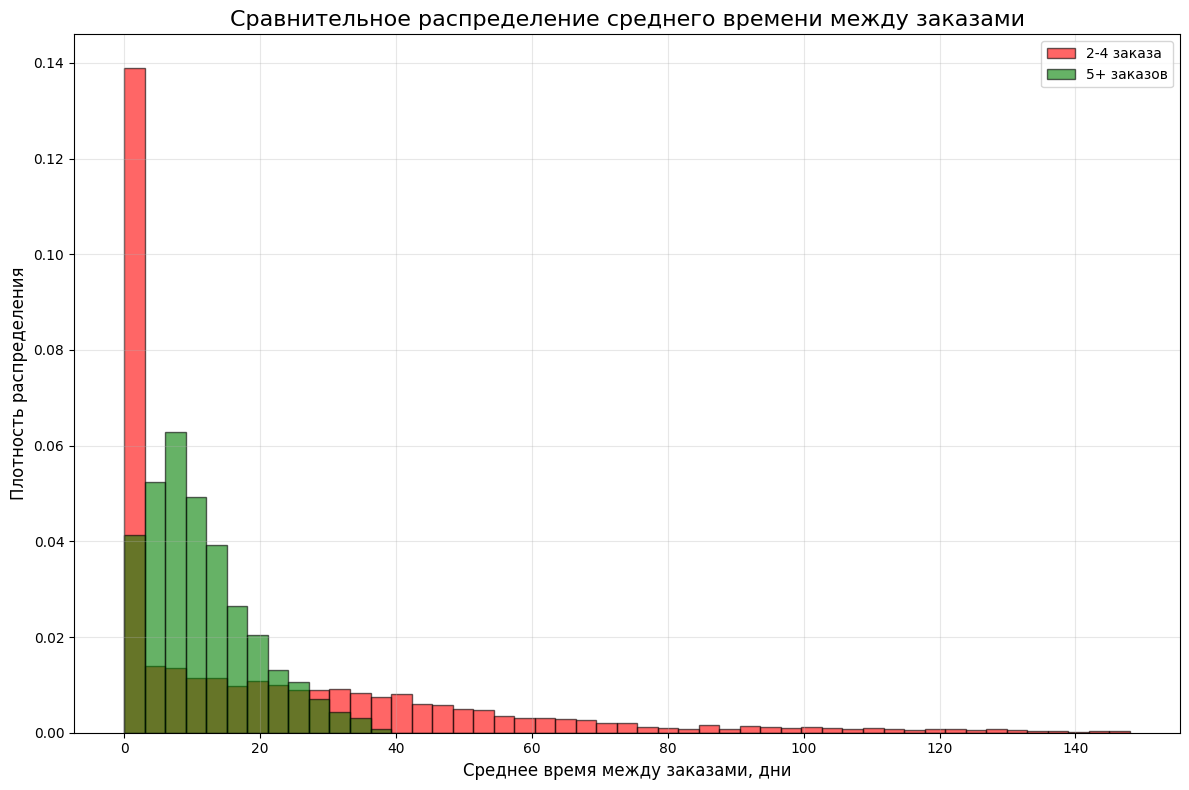

In [129]:
plt.figure(figsize=(12, 8))

data_range = np.linspace(
    min(group_2_4['avg_days_between_orders'].min(), group_5_plus['avg_days_between_orders'].min()),
    max(group_2_4['avg_days_between_orders'].max(), group_5_plus['avg_days_between_orders'].max()),
    50
)

plt.hist(group_2_4['avg_days_between_orders'], bins=data_range, alpha=0.6, color='red', 
         label='2-4 заказа', edgecolor='black', density=True)
plt.hist(group_5_plus['avg_days_between_orders'], bins=data_range, alpha=0.6, color='green', 
         label='5+ заказов', edgecolor='black', density=True)

plt.title('Сравнительное распределение среднего времени между заказами', fontsize=16)
plt.xlabel('Среднее время между заказами, дни', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По гистограмме распределения можно заметить, что большое количество пользователей (2446) с количеством заказов 2-4 совершают их в один день и далее не пользуются сервисом, поэтому если пользователь сделал до 4-х заказов в один день, то не маленькая вероятность того, что это были его первые и последние заказы
</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [130]:
user_profile.head()

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five,ticket_segment,first_order_weekday,lifetime_days,lifetime_segment
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,0,0,3-5 билетов,Tuesday,72,31-90 дней
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,1,0,3-5 билетов,Tuesday,100,90+ дней
2,000898990054619,2024-07-13,2024-10-23,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,1,0,2-3 билета,Saturday,110,90+ дней
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,каменевский регион,край билетов,театр,1,917.830000,4.000000,NaN,0,0,3-5 билетов,Thursday,77,31-90 дней
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,поленовский край,лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0,1-2 билета,Sunday,32,31-90 дней


In [131]:
correlation = user_profile[['total_orders', 'avg_days_between_orders', 'lifetime_days', 'avg_tickets', 
                            'first_device', 'first_region', 'first_partner', 'first_genre', 
                            'avg_revenue_rub', 'first_order_weekday'
                           ]].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 
                                                         'avg_days_between_orders', 'avg_tickets', 
                                                         'total_orders'])

In [132]:
correlation

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.490119,0.425755,0.343184,0.051420,0.027257,0.038499,0.029430,0.263645,0.019582
avg_days_between_orders,0.490119,1.000000,0.393404,0.091253,0.018204,0.091438,0.060388,0.052714,0.106567,0.000000
lifetime_days,0.425755,0.393404,1.000000,0.206835,0.033108,0.343285,0.209568,0.150950,0.211164,0.139921
avg_tickets,0.343184,0.091253,0.206835,1.000000,0.060481,0.095637,0.081450,0.099236,0.451883,0.004911
first_device,0.051420,0.018204,0.033108,0.060481,1.000000,0.110750,0.084303,0.063852,0.076539,0.074147
first_region,0.027257,0.091438,0.343285,0.095637,0.110750,1.000000,0.696542,0.507089,0.363034,0.138937
first_partner,0.038499,0.060388,0.209568,0.081450,0.084303,0.696542,1.000000,0.586853,0.385837,0.063487
first_genre,0.029430,0.052714,0.150950,0.099236,0.063852,0.507089,0.586853,1.000000,0.334133,0.082344
avg_revenue_rub,0.263645,0.106567,0.211164,0.451883,0.076539,0.363034,0.385837,0.334133,1.000000,0.000000
first_order_weekday,0.019582,0.000000,0.139921,0.004911,0.074147,0.138937,0.063487,0.082344,0.000000,1.000000


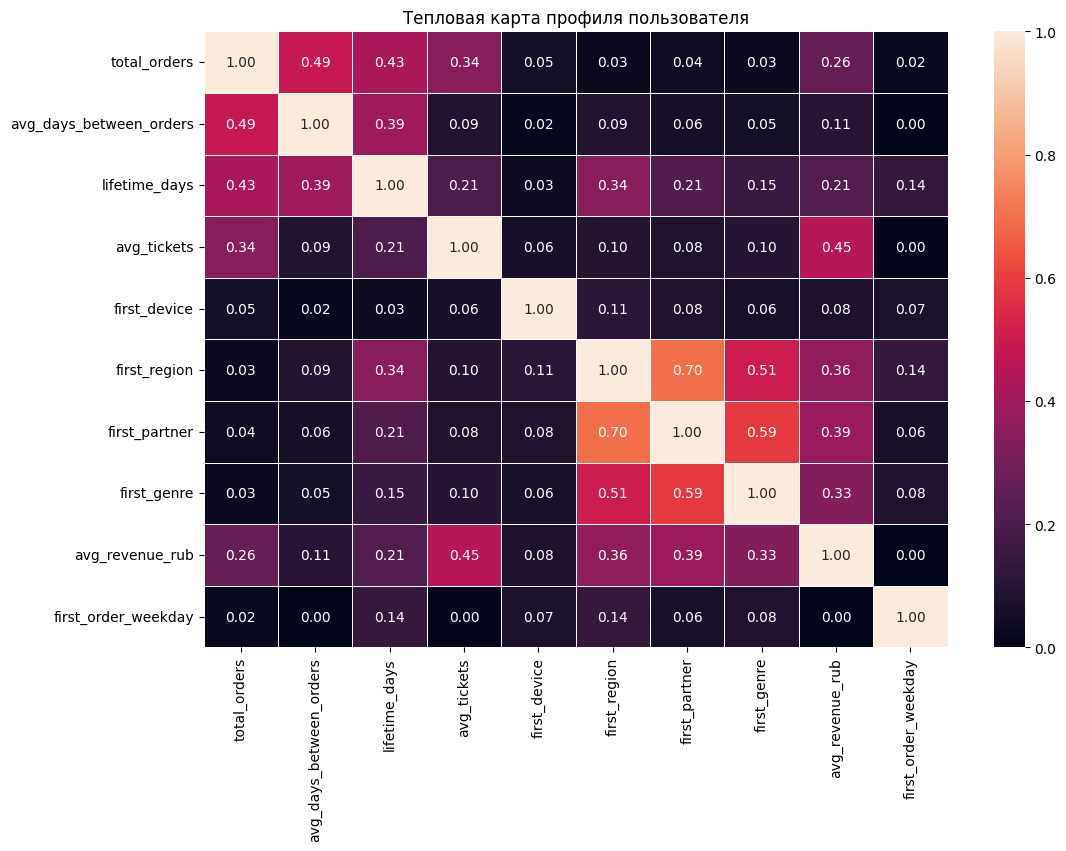

In [133]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [134]:
group_1 = user_profile[user_profile['total_orders'] == 1]

In [135]:
correlation_1 = group_1[['avg_days_between_orders', 'lifetime_days', 'avg_tickets', 'first_device', 
                         'first_region', 'first_partner', 'first_genre', 'avg_revenue_rub',
                         'first_order_weekday'
                        ]].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 
                                                      'avg_days_between_orders', 'avg_tickets'])
correlation_1

,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
avg_days_between_orders,1.000000,0.000000,0.000000,0.000000,0.726203,0.559016,0.314606,0.000000,0.000000
lifetime_days,0.000000,1.000000,0.057139,0.000000,0.342183,0.227877,0.144951,0.101474,0.132728
avg_tickets,0.000000,0.057139,1.000000,0.060933,0.000000,0.084395,0.106476,0.354516,0.020147
first_device,0.000000,0.000000,0.060933,1.000000,0.095228,0.072346,0.061981,0.093945,0.072942
first_region,0.726203,0.342183,0.000000,0.095228,1.000000,0.667929,0.504344,0.400970,0.132363
first_partner,0.559016,0.227877,0.084395,0.072346,0.667929,1.000000,0.580572,0.446305,0.058075
first_genre,0.314606,0.144951,0.106476,0.061981,0.504344,0.580572,1.000000,0.377835,0.095534
avg_revenue_rub,0.000000,0.101474,0.354516,0.093945,0.400970,0.446305,0.377835,1.000000,0.000000
first_order_weekday,0.000000,0.132728,0.020147,0.072942,0.132363,0.058075,0.095534,0.000000,1.000000


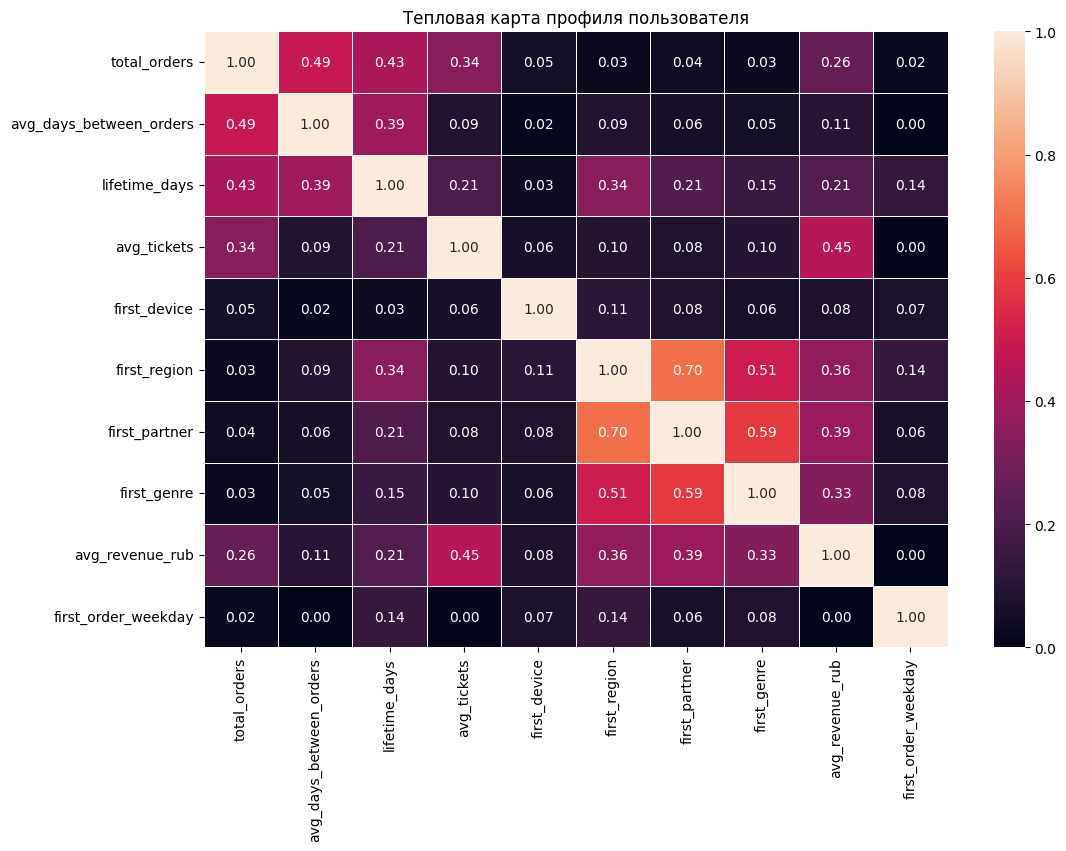

In [136]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [137]:
correlation_2_4 = group_2_4[['total_orders', 'avg_days_between_orders', 'lifetime_days', 'avg_tickets', 
                             'first_device', 'first_region', 'first_partner', 'first_genre', 
                             'avg_revenue_rub', 'first_order_weekday'
                            ]].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 
                                                          'avg_days_between_orders', 
                                                          'avg_tickets', 'total_orders'])
correlation_2_4

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.385958,0.151724,0.287995,0.006184,0.000000,0.056344,0.000000,0.108443,0.000000
avg_days_between_orders,0.385958,1.000000,0.577877,0.158332,0.034701,0.121185,0.080362,0.064577,0.175035,0.000000
lifetime_days,0.151724,0.577877,1.000000,0.083283,0.000000,0.350558,0.221036,0.145332,0.142021,0.152641
avg_tickets,0.287995,0.158332,0.083283,1.000000,0.071143,0.000000,0.037855,0.081991,0.434227,0.000000
first_device,0.006184,0.034701,0.000000,0.071143,1.000000,0.105094,0.074078,0.059856,0.057283,0.076233
first_region,0.000000,0.121185,0.350558,0.000000,0.105094,1.000000,0.684497,0.476153,0.317752,0.138754
first_partner,0.056344,0.080362,0.221036,0.037855,0.074078,0.684497,1.000000,0.576719,0.394741,0.078679
first_genre,0.000000,0.064577,0.145332,0.081991,0.059856,0.476153,0.576719,1.000000,0.328554,0.057380
avg_revenue_rub,0.108443,0.175035,0.142021,0.434227,0.057283,0.317752,0.394741,0.328554,1.000000,0.000000
first_order_weekday,0.000000,0.000000,0.152641,0.000000,0.076233,0.138754,0.078679,0.057380,0.000000,1.000000


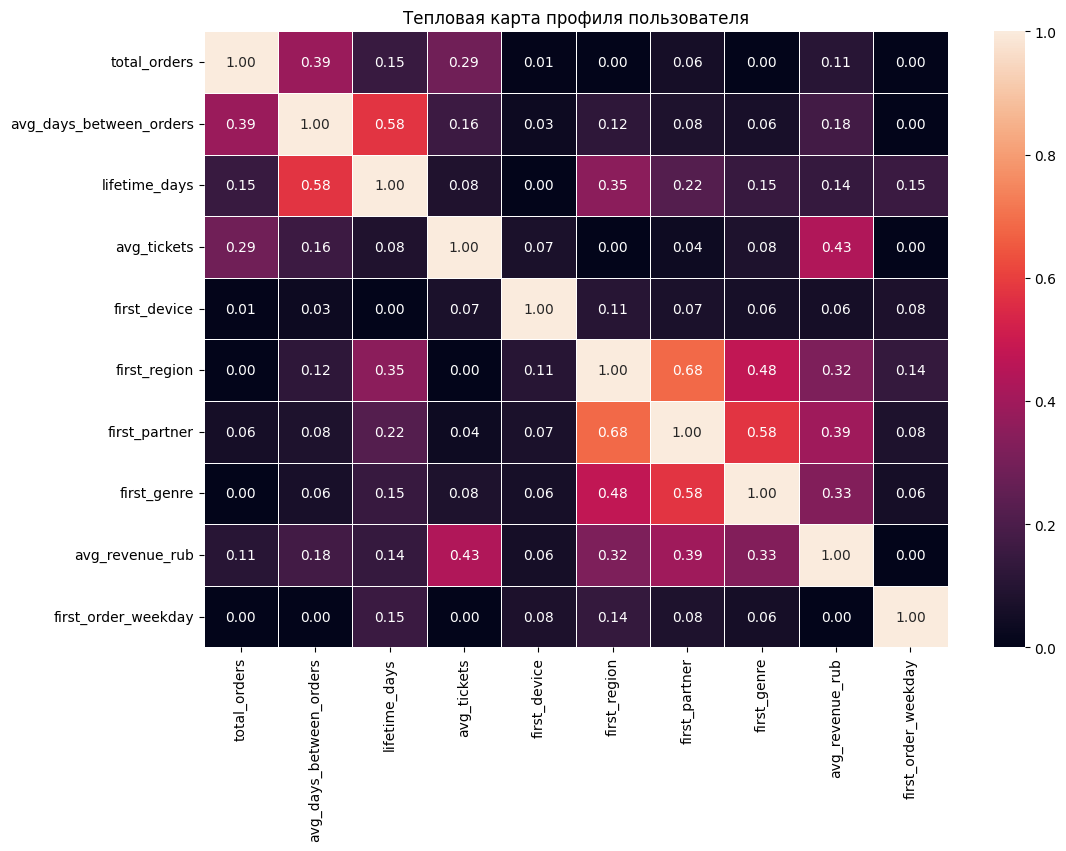

In [138]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation_2_4, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя')
plt.show()

In [139]:
correlation_5_plus = group_5_plus[['total_orders','avg_days_between_orders', 'lifetime_days', 'avg_tickets', 
                                   'first_device', 'first_region', 'first_partner', 'first_genre', 
                                   'avg_revenue_rub', 'first_order_weekday'
                                  ]].phik_matrix(interval_cols=['lifetime_days', 'avg_revenue_rub', 
                                                                'avg_days_between_orders', 
                                                                'avg_tickets', 'total_orders'])
correlation_5_plus

,total_orders,avg_days_between_orders,lifetime_days,avg_tickets,first_device,first_region,first_partner,first_genre,avg_revenue_rub,first_order_weekday
total_orders,1.000000,0.713088,0.335883,0.199987,0.034160,0.070482,0.070857,0.046115,0.167142,0.000000
avg_days_between_orders,0.713088,1.000000,0.617185,0.235328,0.000000,0.175840,0.000000,0.127245,0.277629,0.026057
lifetime_days,0.335883,0.617185,1.000000,0.234761,0.026989,0.372370,0.218648,0.187942,0.282993,0.149697
avg_tickets,0.199987,0.235328,0.234761,1.000000,0.060993,0.132250,0.063838,0.124827,0.457823,0.015194
first_device,0.034160,0.000000,0.026989,0.060993,1.000000,0.153247,0.094627,0.072028,0.070544,0.066977
first_region,0.070482,0.175840,0.372370,0.132250,0.153247,1.000000,0.683974,0.532127,0.362528,0.205978
first_partner,0.070857,0.000000,0.218648,0.063838,0.094627,0.683974,1.000000,0.574484,0.278599,0.087122
first_genre,0.046115,0.127245,0.187942,0.124827,0.072028,0.532127,0.574484,1.000000,0.253125,0.091067
avg_revenue_rub,0.167142,0.277629,0.282993,0.457823,0.070544,0.362528,0.278599,0.253125,1.000000,0.000000
first_order_weekday,0.000000,0.026057,0.149697,0.015194,0.066977,0.205978,0.087122,0.091067,0.000000,1.000000


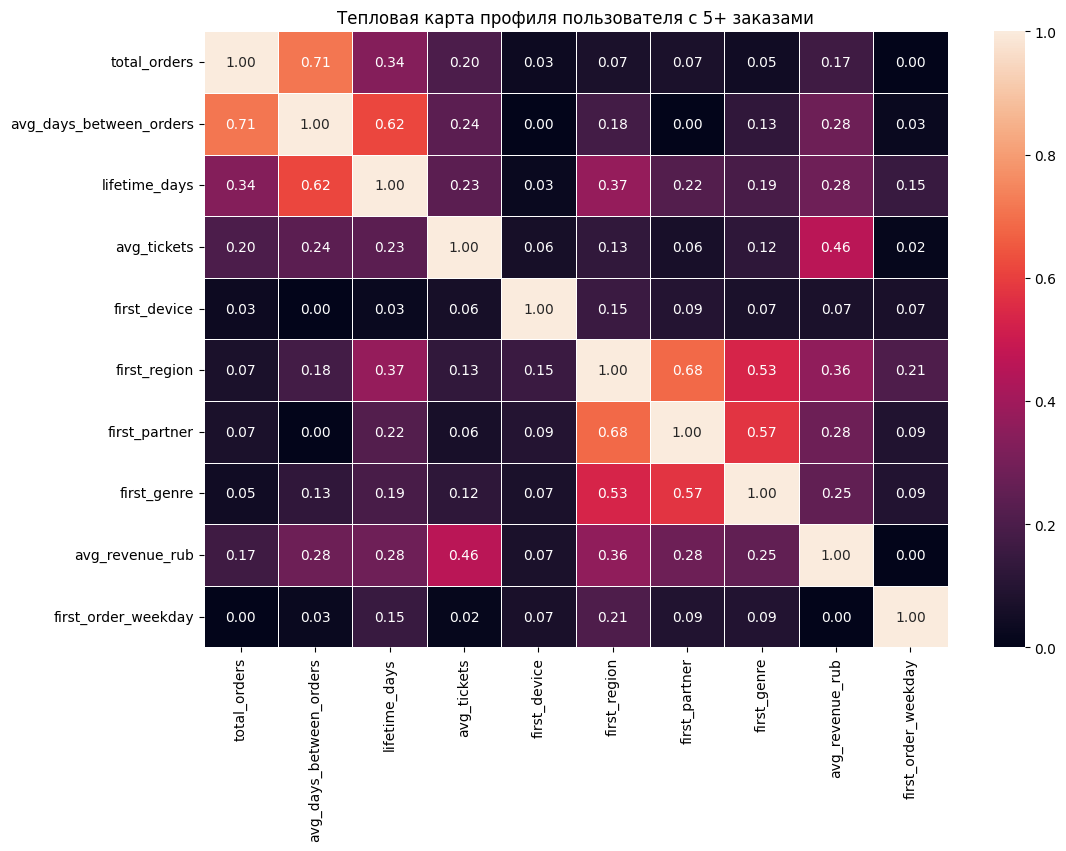

In [140]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=correlation_5_plus, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта профиля пользователя с 5+ заказами')
plt.show()

<div style="font-size: 18px; line-height: 1.5; color: blue;">
По тепловым картам, особенно для пользователей с 5+ заказами есть связь количества заказов со средним количеством дней между заказами (0.71), а также связь со временем между первой покупкой и настоящей датой. Так же могу отметить связь региона и оператора билетов - логично, что операторы могут изначально базироваться в определенных регионах и только позднее распространяться на другие
</div>

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

#### Общий обзор проделанной работы

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
<li>В ходе исследования проанализировано и обработано 290611 записей о совершенных пользователями заказов в сервисе по продаже билетов на мероприятия, такие как концерты, кино, театр, спорт и др.</li>
    <li>Значения в столбце revenue были приведены к единой валюте - рублям и занесены в новый столбец revenue_rub, т.к. в существующем revenue значения были представлены как в рублях, так и в тенге</li>
    <li>Так же было отфильровано 2917 записей с аномально большой стоимостью и количеством билетов в заказе для более точного последующего анализа</li>
    <li>Нормализованы столбцы city_name, region_name, event_type_main, service_name</li>
</ul>
</div>

#### Ответы на исследовательские вопросы, или главные выводы

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
    <li>Всего в предоставленной выборке 21849 пользователей после фильтрации, которые в свою очередь были так же отфильтрованы до 20146 из-за выбросов по числу заказов</li>
    <li>У ~41.5% пользователей только 1 заказ</li>
    <li>Основным поставщиком билетов является 'билеты без проблем' - ~23.86% что почти в 2 раза больше чем у оператора на втором месте</li>
    <li>В основном у клиентов в заказе 2 или 3 билета</li>
    <li>Концерты - наиболее популярный тип билетов для первого заказа - их ~44% по сравнению с 'другое' (~25%)</li>
    <li>В основном первый заказ делают с мобильного устройства - почти 83% пользователей</li>
    <li>А из регонов для первого мероприятия выделяются 'каменевский регион' - 32.43% и 'североярская область' - 17.29%</li>
    <li>Наиболее часто новые клиенты делают заказ в пятницу и субботу</li>
    <li>Наиболее выгодными днями недели являются понедельник и среда - если пользователь сделал свой первый заказ в эти дни, вероятность сделать повторный заказ выше</li>
    <li>Высокий процент клиентов с повторными покупками у сегмента с 2-3 билетами (70.61%)</li>
    <li>Вероятность повторной покупки выше, если средняя выручка приближена к средним значениям выручки по выборке</li>
    <li>Наибольшее число заказов у пользователей, которые делают их с интервалом 4-7 дней</li>
    <li>По результатам кореляционного анализа есть связь количества заказов со средним количеством дней между заказами (0.71), а также связь со временем между первой покупкой и настоящей датой (lifetime)</li>
</ul>
</div>

#### Рекомендации на основе анализа данных

<div style="font-size: 18px; line-height: 1.5; color: blue;">
<ul>
    <li>Сделать основной упор на мобильное приложение, т.к. 83% пользователей делают первый заказ именно через него</li>
    <li>Сконцентрировать маркетинговые бюджеты на "Каменевском регионе" (32.43%) и "Североярской области" (17.29%)</li>
    <li>Возможно стоит обратить внимание на клиентов, у которых первый заказ содержит только один билет - вероятность возврата такого клиента ниже</li>
    <li>Пик новых заказов в пятницу-субботу - усилить рекламу в эти дни</li>
    <li>Из-за большой процента пользователей с одним заказом (41.5%) подумать над программой акций для второго заказа</li>
    <li>Интервал 4-7 дней между заказами - оптимальное время для напоминаний (пуши, email)</li>
    <li>Выручка близкая к средним значениям дает больше повторных покупок, поэтому стоит избегать слишком дешевых и дорогих предложений</li>
</ul>
</div>